In [2]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
import numpy as np
import os,random, math
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# from dataprep.eda import plot, plot_correlation, plot_missing

import plotly 
import plotly.express as px
# from plotly import tools, subplots
# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# from plotly.offline import init_notebook_mode, iplot
# import plotly.graph_objs as go
# import plotly.express as px

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# cf.) function

In [152]:
def read_file(filename):
    df = pd.read_csv(f'{filename}')
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

def check_NA(df):=
    print(f"NA check")
    NA_res = df.isna().sum()
    if NA_res.sum() != 0:
        for idx, i in enumerate(NA_res):
            if i != 0:
                print(df.columns[idx],i,"->",round(i/df.shape[0]*100,3),"%")
    else:
        print("...There's no NA")

def get_values(data, code, col):
    df = data[(data['단지코드']==code)&(data[col].isna()==False)]
    return df[col].values.mean()

def impute_by_code(data, col, verbose=True):
    code = data[data[col].isna()==True]['단지코드'].unique()
    if verbose == True:
        print(f"{col}에 NA가 있는 단지코드: {code}")
        print(f"{col}이(가) 모두 NA인 단지코드:")
    for i in code:
        n = data[(data['단지코드']==i)&(data[col].isna()==False)].shape[0]
        ind = data[(data['단지코드']==i)&(data[col].isna()==True)].index
        if n != 0 :
            data.loc[ind,col] = get_values(data, i, col)
        if n==0 and verbose == True:
            print(i)
    return data    

def mapping_by_key(dic, x):
    for i in dic.keys():
        if x in dic[i]:
            return int(i)

def make_dummies(data, col):
    sample = pd.DataFrame(data.groupby('단지코드')[col].unique()).reset_index()
    for i in dic.keys():
        data[col.split('_')[0]+str(i)]=0
    for i in sample.index:
        code = sample.loc[i,'단지코드']
        val = sample.loc[i,col]
        ind = data[data['단지코드']==code].index
        for j in val:
            data.loc[ind,col.split('_')[0]+str(j)] = 1
    return data

def dual_countplot(col, train, test, figsize=(14,8), pallete="Set2", flip=True):
    plt.rcParams["figure.figsize"] = figsize
    fig, ax = plt.subplots(ncols=2)
    if flip:
        sns.countplot(y=train[col],palette=pallete,order=sorted(train[col].unique()),ax=ax[0]).set_title("train")
        sns.countplot(y=test[col],palette=pallete,order=sorted(test[col].unique()),ax=ax[1]).set_title("test")
    else:
        sns.countplot(x=train[col],palette=pallete,order=sorted(train[col].unique()),ax=ax[0]).set_title("train")
        sns.countplot(x=test[col],palette=pallete,order=sorted(test[col].unique()),ax=ax[1]).set_title("test")
    plt.tight_layout()
    plt.show()

**Problem** <br>
▶**단지코드별 등록차량수를 predict하는 regression 문제**

**Evaluation** <br>
▶**MAE**

## duplicates 제거 & column명 변경

In [3]:
filepath = "./data"

In [61]:
train = read_file(os.path.join(filepath,'train.csv'))
test = read_file(os.path.join(filepath,'test.csv'))
age_gender = read_file(os.path.join(filepath,'age_gender_info.csv'))

...There are 320 duplicates
...Remove them
shape: (2632, 15)
...There are 73 duplicates
...Remove them
shape: (949, 14)
...There are no duplicates
shape: (16, 23)


In [62]:
print(train.columns)
print(test.columns)
print(age_gender.columns)

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수'],
      dtype='object')
Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수'],
      dtype='object')
Index(['지역', '10대미만(여자)', '10대미만(남자)', '10대(여자)', '10대(남자)', '20대(여자)',
       '20대(남자)', '30대(여자)', '30대(남자)', '40대(여자)', '40대(남자)', '50대(여자)',
       '50대(남자)', '60대(여자)', '60대(남자)', '70대(여자)', '70대(남자)', '80대(여자)',
       '80대(남자)', '90대(여자)', '90대(남자)', '100대(여자)', '100대(남자)'],
      dtype='object')


In [63]:
train.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역',
       '버스정류장', '단지내주차면수', '등록차량수']
test.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역',
       '버스정류장', '단지내주차면수']

# new_age_gender_col = ['지역', '0F', '0M']
# for i in age_gender.columns[3:]:
#     if '여' in i.split('대')[1]:
#         col = i.split('대')[0]+"F"
#     else:
#         col = i.split('대')[0]+"M"
#     new_age_gender_col.append(col)
# age_gender.columns = new_age_gender_col


print(train.columns)
print(test.columns)
print(age_gender.columns)

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수'],
      dtype='object')
Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수'],
      dtype='object')
Index(['지역', '10대미만(여자)', '10대미만(남자)', '10대(여자)', '10대(남자)', '20대(여자)',
       '20대(남자)', '30대(여자)', '30대(남자)', '40대(여자)', '40대(남자)', '50대(여자)',
       '50대(남자)', '60대(여자)', '60대(남자)', '70대(여자)', '70대(남자)', '80대(여자)',
       '80대(남자)', '90대(여자)', '90대(남자)', '100대(여자)', '100대(남자)'],
      dtype='object')


## datatype 변경
1) categorical
- 단지코드
- 임대건물구분
- 지역
- 공급유형
- 자격유형

2) numerical
- 총세대수
- 전용면적
- 전용면적별세대수
- 공가수
- **임대보증금: "-" -> NA 처리 후 numeric으로 변경**
- **임대료: "-" -> NA 처리 후 numeric으로 변경**
- 도보 10분거리 내 지하철역 수(환승노선 수 반영)
- 도보 10분거리 내 버스정류장 수
- 단지내주차면수
- 등록차량수

In [7]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2632 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      2632 non-null   object 
 1   총세대수      2632 non-null   int64  
 2   임대건물구분    2632 non-null   object 
 3   지역        2632 non-null   object 
 4   공급유형      2632 non-null   object 
 5   전용면적      2632 non-null   float64
 6   전용면적별세대수  2632 non-null   int64  
 7   공가수       2632 non-null   float64
 8   자격유형      2632 non-null   object 
 9   임대보증금     2340 non-null   object 
 10  임대료       2340 non-null   object 
 11  지하철역      2477 non-null   float64
 12  버스정류장     2628 non-null   float64
 13  단지내주차면수   2632 non-null   float64
 14  등록차량수     2632 non-null   float64
dtypes: float64(6), int64(2), object(7)
memory usage: 329.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 949 entries, 0 to 1021
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    ------

In [8]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역', '버스정류장', '단지내주차면수', '등록차량수'],
      dtype='object')

In [9]:
train.select_dtypes(exclude='number')

,단지코드,임대건물구분,지역,공급유형,자격유형,임대보증금,임대료
0,C2483,아파트,경상북도,국민임대,A,15667000,103680
1,C2483,아파트,경상북도,국민임대,A,15667000,103680
2,C2483,아파트,경상북도,국민임대,A,27304000,184330
3,C2483,아파트,경상북도,국민임대,A,27304000,184330
4,C2483,아파트,경상북도,국민임대,A,27304000,184330
...,...,...,...,...,...,...,...
2947,C2532,아파트,강원도,국민임대,A,11346000,116090
2948,C2532,아파트,강원도,국민임대,A,14005000,142310
2949,C2532,아파트,강원도,국민임대,A,14005000,142310
2950,C2532,아파트,강원도,국민임대,A,14005000,142310


In [10]:
train.임대료.value_counts()

-         21
390000    19
100920    16
79980     16
590000    14
          ..
249840     1
89220      1
98610      1
321510     1
199200     1
Name: 임대료, Length: 995, dtype: int64

In [11]:
for col in ['임대료','임대보증금']:
    train[col] = train[col].replace('-',np.nan)
    train[col].fillna(-1,inplace=True)
    train[col] = train[col].astype('float')
    train[col] = train[col].replace(-1,np.nan)

for col in ['임대료','임대보증금']:
    test[col] = test[col].replace('-',np.nan)
    test[col].fillna(-1,inplace=True)
    test[col] = test[col].astype('float')
    test[col] = test[col].replace(-1,np.nan)

In [12]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2632 entries, 0 to 2951
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      2632 non-null   object 
 1   총세대수      2632 non-null   int64  
 2   임대건물구분    2632 non-null   object 
 3   지역        2632 non-null   object 
 4   공급유형      2632 non-null   object 
 5   전용면적      2632 non-null   float64
 6   전용면적별세대수  2632 non-null   int64  
 7   공가수       2632 non-null   float64
 8   자격유형      2632 non-null   object 
 9   임대보증금     2328 non-null   float64
 10  임대료       2319 non-null   float64
 11  지하철역      2477 non-null   float64
 12  버스정류장     2628 non-null   float64
 13  단지내주차면수   2632 non-null   float64
 14  등록차량수     2632 non-null   float64
dtypes: float64(8), int64(2), object(5)
memory usage: 329.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 949 entries, 0 to 1021
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    ------

## NA 확인
- 임대보증금&임대료
- 지하철역&버스정류장
- 자격유형

In [14]:
check_NA(train)
check_NA(test)
check_NA(age_gender)

NA check
임대보증금 304 -> 11.55 %
임대료 313 -> 11.892 %
지하철역 155 -> 5.889 %
버스정류장 4 -> 0.152 %
NA check
자격유형 2 -> 0.211 %
임대보증금 120 -> 12.645 %
임대료 120 -> 12.645 %
지하철역 34 -> 3.583 %
NA check
...There's no NA


In [15]:
raw_train = deepcopy(train)
raw_test = deepcopy(test)
raw_age_gender = deepcopy(age_gender)

# EDA
## age_gender_info

In [16]:
age = age_gender.set_index('지역')

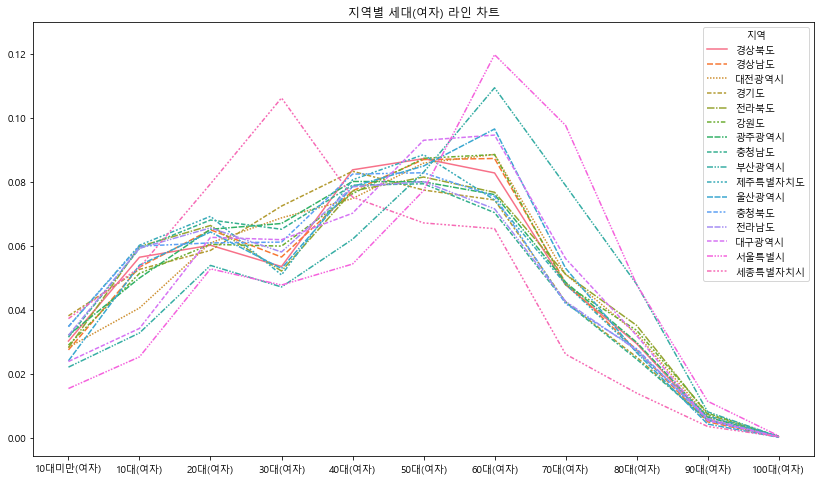

In [17]:
plt.rcParams["figure.figsize"] = (14,8)
sns.lineplot(data=age.loc[:, age.columns.str.contains('여자')].T)
plt.title('지역별 세대(여자) 라인 차트')
plt.ylim(top=0.13)
plt.show()

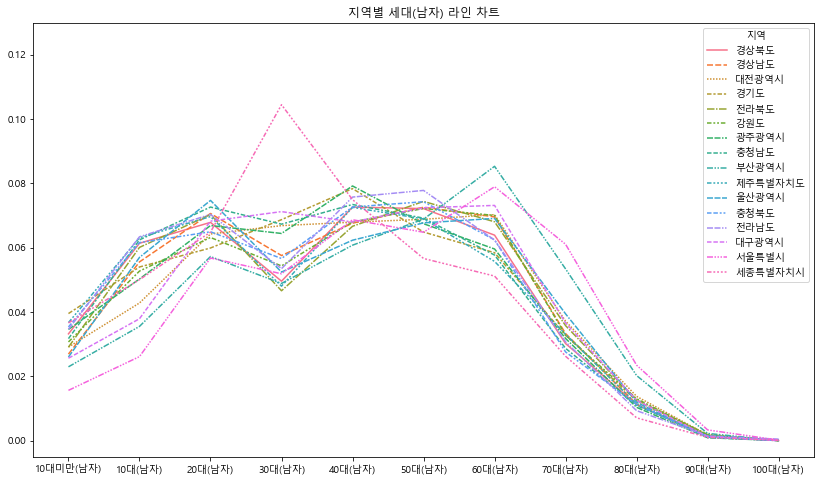

In [18]:
plt.rcParams["figure.figsize"] = (14,8)
sns.lineplot(data=age.loc[:, age.columns.str.contains('남자')].T)
plt.title('지역별 세대(남자) 라인 차트')
plt.ylim(top=0.13)
plt.show()

## train & test
**categorical feature**
- 단지코드
- 지역
- 임대건물구분
- 공급유형
- 자격유형

In [67]:
num_col = train.select_dtypes(include='number').columns.tolist()
obj_col = train.select_dtypes(exclude='number').columns.tolist()
print("categorical feature:")
print(*obj_col, sep="\n")

categorical feature:
단지코드
임대건물구분
지역
공급유형
자격유형


### 단지코드
▶ 단지코드별로 그룹화했을 때 nonunique column들이 있음
- 자격유형, 공급유형, 임대건물구분
- 임대보증금, 임대료, 전용면적, 전용면적별세대수

▶ <font color="red">nonunique column 전처리 후 단지코드별로 그룹화해야 함</font>

In [19]:
comp_groupby = train.groupby(['단지코드']).nunique(dropna=False) # count NA values
comp_groupby

,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역,버스정류장,단지내주차면수,등록차량수
단지코드,,,,,,,,,,,,,,
C1000,1,1,1,1,5,6,1,1,3,3,1,1,1,1
C1004,1,2,1,2,15,3,1,2,3,3,1,1,1,1
C1005,1,1,1,1,3,3,1,1,3,3,1,1,1,1
C1013,1,1,1,1,4,5,1,1,3,3,1,1,1,1
C1014,1,1,1,1,6,7,1,1,4,4,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2663,1,1,1,1,5,6,1,1,4,4,1,1,1,1
C2666,1,1,1,1,4,6,1,1,2,2,1,1,1,1
C2670,1,1,1,1,4,3,1,1,3,3,1,1,1,1


In [20]:
print(comp_groupby.sum())
unique_col = [comp_groupby.sum().index[idx] for (idx, i) in enumerate(comp_groupby.sum()) if i == 423]
nonunique_col =  [comp_groupby.sum().index[idx] for (idx, i) in enumerate(comp_groupby.sum()) if i != 423]
print(f"unique_col: {unique_col}")
print(f"nonunique_col: {nonunique_col}")

총세대수         423
임대건물구분       456
지역           423
공급유형         488
전용면적        1898
전용면적별세대수    2230
공가수          423
자격유형         510
임대보증금       1277
임대료         1289
지하철역         423
버스정류장        423
단지내주차면수      423
등록차량수        423
dtype: int64
unique_col: ['총세대수', '지역', '공가수', '지하철역', '버스정류장', '단지내주차면수', '등록차량수']
nonunique_col: ['임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형', '임대보증금', '임대료']


### 임대건물구분
▶상가만 있는 단지는 X

▶<font color="red">상가비율 column 추가</font> <br>

In [76]:
train_cls = pd.concat([train[['단지코드']], pd.get_dummies(train[['임대건물구분']])], axis=1).groupby('단지코드').sum()
train_cls

,임대건물구분_상가,임대건물구분_아파트
단지코드,,
C1000,0,7
C1004,13,2
C1005,0,3
C1013,0,5
C1014,0,7
...,...,...
C2663,0,6
C2666,0,6
C2670,0,5


In [75]:
print(f"상가만 있는 단지: {train_cls.loc[train_cls.임대건물구분_아파트==0,].shape[0]}")
print(f"상가가 없는 단지: {train_cls.loc[train_cls.임대건물구분_상가==0,].shape[0]}")
print(f"상가가 있는 단지: {train_cls.loc[train_cls.임대건물구분_상가!=0,].shape[0]}")
print(f"상가>아파트인 단지: {train_cls.loc[(train_cls.임대건물구분_상가!=0)&(train_cls.임대건물구분_상가>train_cls.임대건물구분_아파트),].shape[0]}")
print(f"상가=아파트인 단지: {train_cls.loc[(train_cls.임대건물구분_상가!=0)&(train_cls.임대건물구분_상가==train_cls.임대건물구분_아파트),].shape[0]}")
print(f"상가<아파트인 단지: {train_cls.loc[(train_cls.임대건물구분_상가!=0)&(train_cls.임대건물구분_상가<train_cls.임대건물구분_아파트),].shape[0]}")

상가만 있는 단지: 0
상가가 없는 단지: 390
상가가 있는 단지: 33
상가>아파트인 단지: 20
상가=아파트인 단지: 6
상가<아파트인 단지: 7


#### 상가비율
상가비율에 따라 상업용/주거용 단지 구분 가능
- train set

In [79]:
tot = train_cls['임대건물구분_상가']+train_cls['임대건물구분_아파트']
train_cls['상가비율'] = train_cls['임대건물구분_상가']/tot
train_cls

,임대건물구분_상가,임대건물구분_아파트,상가비율
단지코드,,,
C1000,0,7,0.0000
C1004,13,2,0.8667
C1005,0,3,0.0000
C1013,0,5,0.0000
C1014,0,7,0.0000
...,...,...,...
C2663,0,6,0.0000
C2666,0,6,0.0000
C2670,0,5,0.0000


In [80]:
print(f"상업용 단지: {train_cls.loc[train_cls.상가비율>0.8,].shape[0]}")

상업용 단지: 13


In [81]:
train = pd.merge(train,train_cls[['상가비율']].reset_index(),on='단지코드')
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역,버스정류장,단지내주차면수,등록차량수,자격유형_카테고리,자격유형1,자격유형2,자격유형3,자격유형4,자격유형5,자격유형6,자격유형7,자격유형8,상가비율
0,C2483,900,아파트,경상북도,국민임대/장기전세,39.7200,134,38.0000,A,"15,667,000.0000","103,680.0000",0.0000,3.0000,"1,425.0000","1,015.0000",1,1,0,0,0,0,0,0,0,0.0000
1,C2483,900,아파트,경상북도,국민임대/장기전세,39.7200,15,38.0000,A,"15,667,000.0000","103,680.0000",0.0000,3.0000,"1,425.0000","1,015.0000",1,1,0,0,0,0,0,0,0,0.0000
2,C2483,900,아파트,경상북도,국민임대/장기전세,51.9300,385,38.0000,A,"27,304,000.0000","184,330.0000",0.0000,3.0000,"1,425.0000","1,015.0000",1,1,0,0,0,0,0,0,0,0.0000
3,C2483,900,아파트,경상북도,국민임대/장기전세,51.9300,15,38.0000,A,"27,304,000.0000","184,330.0000",0.0000,3.0000,"1,425.0000","1,015.0000",1,1,0,0,0,0,0,0,0,0.0000
4,C2483,900,아파트,경상북도,국민임대/장기전세,51.9300,41,38.0000,A,"27,304,000.0000","184,330.0000",0.0000,3.0000,"1,425.0000","1,015.0000",1,1,0,0,0,0,0,0,0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2627,C2532,239,아파트,강원도,국민임대/장기전세,49.2000,19,7.0000,A,"11,346,000.0000","116,090.0000",0.0000,1.0000,166.0000,146.0000,1,1,0,0,0,0,0,0,0,0.0000
2628,C2532,239,아파트,강원도,국민임대/장기전세,51.0800,34,7.0000,A,"14,005,000.0000","142,310.0000",0.0000,1.0000,166.0000,146.0000,1,1,0,0,0,0,0,0,0,0.0000
2629,C2532,239,아파트,강원도,국민임대/장기전세,51.7300,34,7.0000,A,"14,005,000.0000","142,310.0000",0.0000,1.0000,166.0000,146.0000,1,1,0,0,0,0,0,0,0,0.0000
2630,C2532,239,아파트,강원도,국민임대/장기전세,51.9600,114,7.0000,A,"14,005,000.0000","142,310.0000",0.0000,1.0000,166.0000,146.0000,1,1,0,0,0,0,0,0,0,0.0000


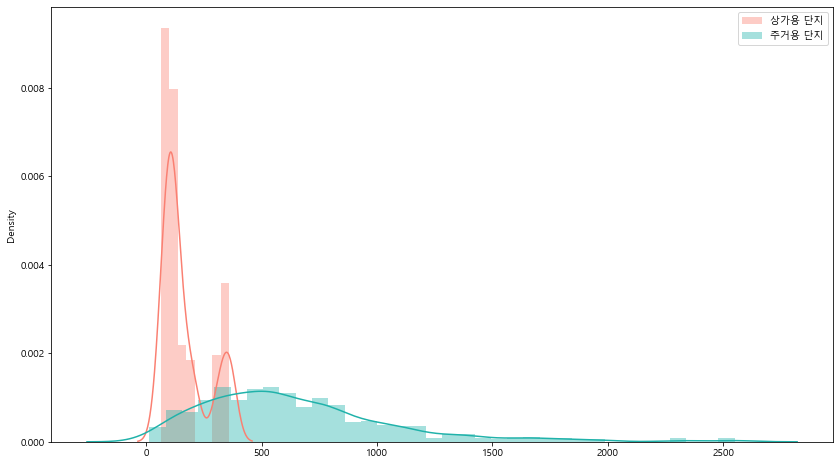

In [82]:
plt.rcParams["figure.figsize"] = (14,8)
sns.distplot(train.loc[train.상가비율>0.8,"등록차량수"], label="상가용 단지", color="salmon")
sns.distplot(train.loc[train.상가비율<0.8,"등록차량수"], label="주거용 단지", color="lightseagreen")
plt.xlabel('')
plt.legend()
plt.show()

- test set

In [83]:
test_cls = pd.concat([test[['단지코드']], pd.get_dummies(test[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = test_cls['임대건물구분_상가']+test_cls['임대건물구분_아파트']
test_cls['상가비율'] = test_cls['임대건물구분_상가']/tot
test = pd.merge(test,test_cls[['상가비율']].reset_index(),on='단지코드')

### 지역
▶ test에는 서울특별시 X

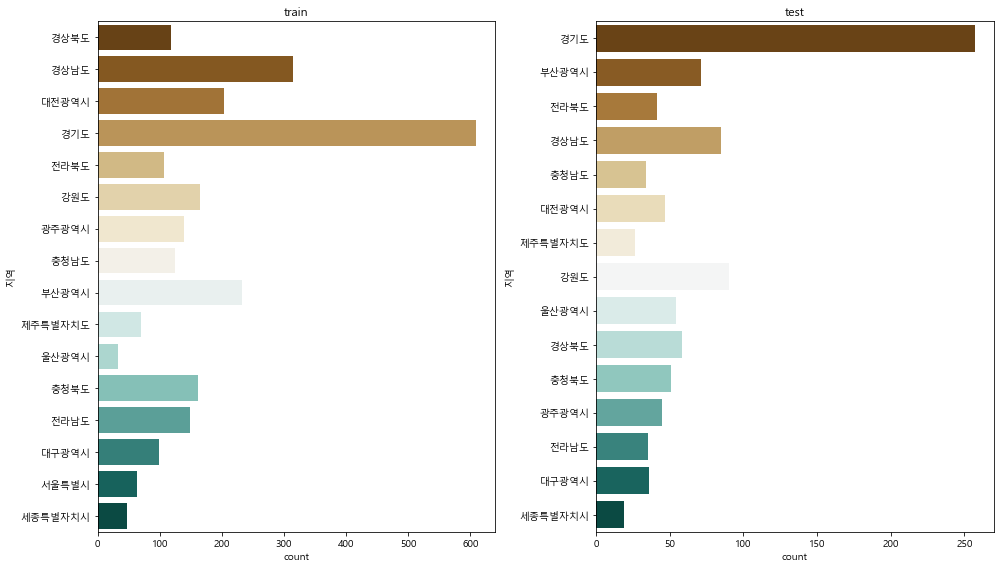

In [150]:
dual_countplot(col="지역", train=train, test=test, pallete="BrBG")

지역별 등록차량수 & 단지내주차면수

In [23]:
train['등록차량수'].groupby(train['지역']).median()

지역
강원도         333.0000
경기도         752.0000
경상남도        479.0000
경상북도        562.0000
광주광역시       713.0000
대구광역시       744.0000
대전광역시       373.0000
부산광역시       345.0000
서울특별시       793.0000
세종특별자치시   1,524.0000
울산광역시       417.0000
전라남도        408.0000
전라북도        415.0000
제주특별자치도     358.0000
충청남도        209.0000
충청북도        553.0000
Name: 등록차량수, dtype: float64

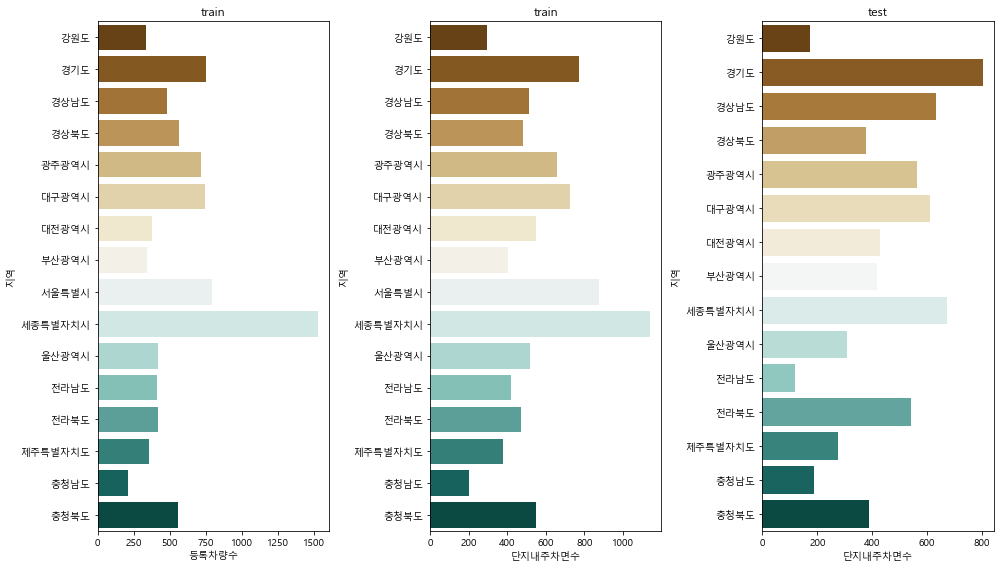

In [25]:
col = "단지내주차면수"
plt.rcParams["figure.figsize"] = (14,8)
fig, ax = plt.subplots(ncols=3)
sns.barplot(data=train["등록차량수"].groupby(train['지역']).median().reset_index(),
            y="지역", x="등록차량수", palette="BrBG", ax=ax[0]).set_title("train")
sns.barplot(data=train[col].groupby(train['지역']).median().reset_index(),
            y="지역", x=f"{col}", palette="BrBG", ax=ax[1]).set_title("train")
sns.barplot(data=test[col].groupby(test['지역']).median().reset_index(),
            y="지역", x=f"{col}", palette="BrBG", ax=ax[2]).set_title("test")
plt.tight_layout()
plt.show()

### 자격유형 & 공급유형
▶<font color="red">자격유형_카테고리 column 추가</font> 

▶test set에 없는 자격유형 - B, F, O

▶<font color="red">공급유형 재범주화</font> 

▶test set에 없는 공급유형 - 장기전세, 공공분양, 공공임대(5년)

In [47]:
print(train.자격유형.nunique())
print(test.자격유형.nunique())
print("test에 없는 자격유형")
print(*set(train.자격유형.unique())-set(test.자격유형.unique()), sep=" ")

15
12
test에 없는 자격유형
B F O


In [48]:
print("test에 없는 공급유형")
print(*set(train.공급유형.unique())-set(test.공급유형.unique()), sep=" ")

test에 없는 공급유형



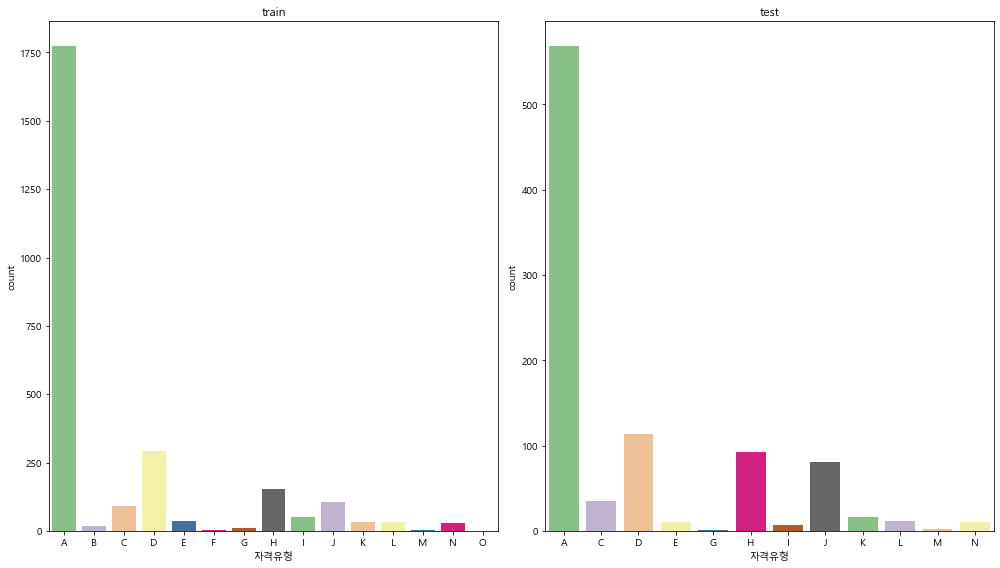

In [153]:
dual_countplot(col="자격유형", train=train, test=test, flip=False, pallete="Accent")

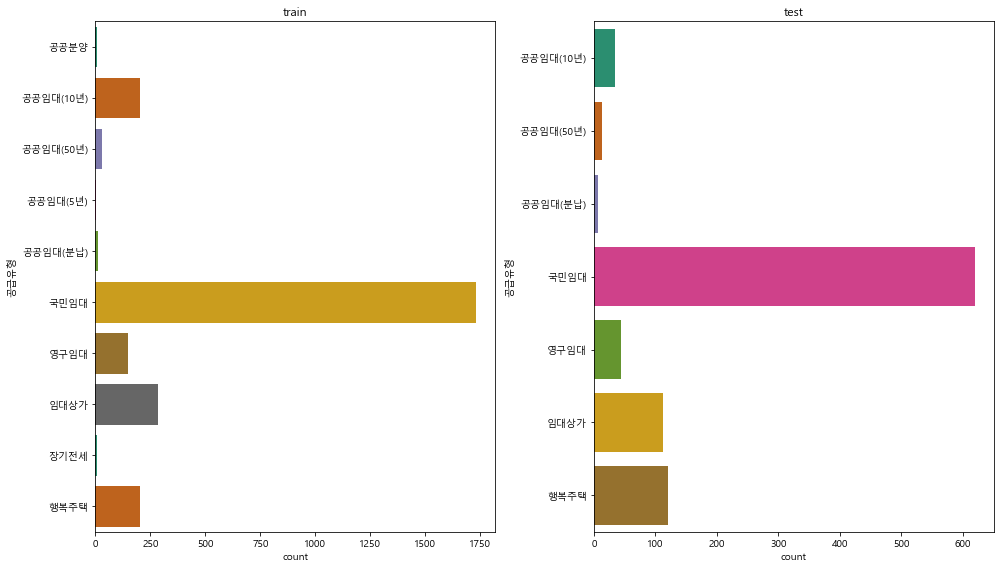

In [157]:
dual_countplot(col="공급유형", train=train, test=test, pallete="Dark2")

#### NA imputation
**해당 단지코드에 위치한 동일 임대건물구분의 자격유형으로 대체**

In [29]:
test.loc[test.자격유형.isna(),'단지코드']

196    C2411
258    C2253
Name: 단지코드, dtype: object

In [30]:
# test.loc[test.단지코드=="C2411",:]
# test.loc[test.단지코드=="C2253",:]

In [124]:
test.loc[(test.단지코드=='C2411')&(test.자격유형.isna()), '자격유형'] = 'A'
test.loc[(test.단지코드=='C2253')&(test.자격유형.isna()), '자격유형'] = 'C'

In [32]:
check_NA(train)
check_NA(test)

NA check
임대보증금 304 -> 11.55 %
임대료 313 -> 11.892 %
지하철역 155 -> 5.889 %
버스정류장 4 -> 0.152 %
NA check
임대보증금 120 -> 12.645 %
임대료 120 -> 12.645 %
지하철역 34 -> 3.583 %


#### 자격유형_카테고리(by 유림)
**전용면적** 기준 8개 범주로 clustering

J / K L M N O / A / B E G H / C / I / E F / D

- train set

In [34]:
for i in train['자격유형'].unique():
    print(i,train[train['자격유형']==i]['공급유형'].unique())

A ['국민임대' '공공임대(50년)' '공공임대(10년)' '공공임대(분납)' '장기전세' '영구임대' '공공임대(5년)']
B ['국민임대']
C ['영구임대']
D ['임대상가' '공공분양']
E ['영구임대' '국민임대']
F ['영구임대']
G ['국민임대']
H ['국민임대']
I ['영구임대']
J ['행복주택']
K ['행복주택']
L ['행복주택']
M ['행복주택']
N ['행복주택']
O ['행복주택']


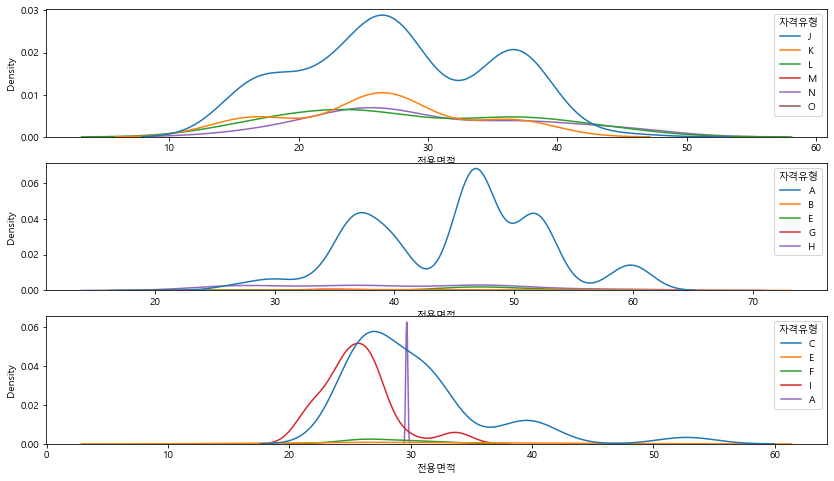

In [37]:
plt.rcParams["figure.figsize"] = (14,8)
fig, ax = plt.subplots(nrows=3)
tmp = train[train['공급유형']=='행복주택']
sns.kdeplot(data=tmp,x='전용면적',color='black',hue='자격유형',ax=ax[0])
tmp = train[train['공급유형']=='국민임대']
sns.kdeplot(data=tmp,x='전용면적',color='black',hue='자격유형',ax=ax[1])
tmp = train[train['공급유형']=='영구임대']
sns.kdeplot(data=tmp,x='전용면적',color='black',hue='자격유형',ax=ax[2])
plt.show()

In [47]:
dic = {'1': 'A' ,'2':['B','E','G','H'],'3':['E','F'],'4':'I','5':['K','L','M','N','O'],'6':'J','7':'C','8':'D'}

In [48]:
train['자격유형_카테고리'] = train['자격유형'].apply(lambda x : mapping_by_key(dic, x))

In [49]:
sample = pd.DataFrame(train.groupby('단지코드')['자격유형_카테고리'].unique()).reset_index()
sample.head()

,단지코드,자격유형_카테고리
0,C1000,[1]
1,C1004,"[7, 8]"
2,C1005,[1]
3,C1013,[1]
4,C1014,[1]


In [71]:
train = make_dummies(train, "자격유형_카테고리")
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역,버스정류장,단지내주차면수,등록차량수,자격유형_카테고리,자격유형1,자격유형2,자격유형3,자격유형4,자격유형5,자격유형6,자격유형7,자격유형8
0,C2483,900,아파트,경상북도,국민임대,39.7200,134,38.0000,A,"15,667,000.0000","103,680.0000",0.0000,3.0000,"1,425.0000","1,015.0000",1,1,0,0,0,0,0,0,0
1,C2483,900,아파트,경상북도,국민임대,39.7200,15,38.0000,A,"15,667,000.0000","103,680.0000",0.0000,3.0000,"1,425.0000","1,015.0000",1,1,0,0,0,0,0,0,0
2,C2483,900,아파트,경상북도,국민임대,51.9300,385,38.0000,A,"27,304,000.0000","184,330.0000",0.0000,3.0000,"1,425.0000","1,015.0000",1,1,0,0,0,0,0,0,0
3,C2483,900,아파트,경상북도,국민임대,51.9300,15,38.0000,A,"27,304,000.0000","184,330.0000",0.0000,3.0000,"1,425.0000","1,015.0000",1,1,0,0,0,0,0,0,0
4,C2483,900,아파트,경상북도,국민임대,51.9300,41,38.0000,A,"27,304,000.0000","184,330.0000",0.0000,3.0000,"1,425.0000","1,015.0000",1,1,0,0,0,0,0,0,0


- test set

In [72]:
test['자격유형_카테고리'] = test['자격유형'].apply(lambda x : mapping_by_key(dic, x))
test = make_dummies(test, "자격유형_카테고리")
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역,버스정류장,단지내주차면수,자격유형_카테고리,자격유형1,자격유형2,자격유형3,자격유형4,자격유형5,자격유형6,자격유형7,자격유형8
0,C1072,754,아파트,경기도,국민임대,39.7900,116,14.0000,H,"22,830,000.0000","189,840.0000",0.0000,2.0000,683.0000,2,1,1,0,0,0,0,0,0
1,C1072,754,아파트,경기도,국민임대,46.8100,30,14.0000,A,"36,048,000.0000","249,930.0000",0.0000,2.0000,683.0000,1,1,1,0,0,0,0,0,0
2,C1072,754,아파트,경기도,국민임대,46.9000,112,14.0000,H,"36,048,000.0000","249,930.0000",0.0000,2.0000,683.0000,2,1,1,0,0,0,0,0,0
3,C1072,754,아파트,경기도,국민임대,46.9000,120,14.0000,H,"36,048,000.0000","249,930.0000",0.0000,2.0000,683.0000,2,1,1,0,0,0,0,0,0
4,C1072,754,아파트,경기도,국민임대,51.4600,60,14.0000,H,"43,497,000.0000","296,780.0000",0.0000,2.0000,683.0000,2,1,1,0,0,0,0,0,0


#### 공급유형 재범주화(by 은영)
5개 범주로 clustering

- <font color="red">공공임대(5년), 공공분양, 공공임대(10년), 공공임대(분납) -> 공공임대(5년/10년/분납/분양)</font>

- <font color="red">장기전세, 국민임대 -> 국민임대/장기전세</font> <br>
장기 거주 측면에서 묶어볼 수 있음

In [33]:
print(*set(train.공급유형), sep=" ")
print(*set(test.공급유형), sep=" ")

공공분양 공공임대(분납) 영구임대 임대상가 행복주택 공공임대(10년) 공공임대(50년) 국민임대 공공임대(5년) 장기전세
공공임대(분납) 영구임대 임대상가 행복주택 공공임대(10년) 공공임대(50년) 국민임대


In [34]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
train.loc[train.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'
test.loc[test.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'

In [35]:
print(*set(train.공급유형), sep=" ")
print(*set(test.공급유형), sep=" ")

영구임대 임대상가 행복주택 국민임대/장기전세 공공임대(50년) 공공임대(5년/10년/분납/분양)
영구임대 임대상가 행복주택 국민임대/장기전세 공공임대(50년) 공공임대(5년/10년/분납/분양)


#### 자격유형_카테고리(by 은영)
**공급유형** 기준 5개 범주로 clustering

J K L M N O / A / B E G H / C F I / D 

- train set

In [66]:
for i in train['자격유형'].unique():
    print(i,train[train['자격유형']==i]['공급유형'].unique())

A ['국민임대/장기전세' '공공임대(50년)' '공공임대(5년/10년/분납/분양)' '영구임대']
B ['국민임대/장기전세']
C ['영구임대']
D ['임대상가' '공공임대(5년/10년/분납/분양)']
E ['영구임대' '국민임대/장기전세']
F ['영구임대']
G ['국민임대/장기전세']
H ['국민임대/장기전세']
I ['영구임대']
J ['행복주택']
K ['행복주택']
L ['행복주택']
M ['행복주택']
N ['행복주택']
O ['행복주택']


1) 자격유형이 A인 공급유형
- 4개의 공급유형이 혼재되어 있어 그룹화 X

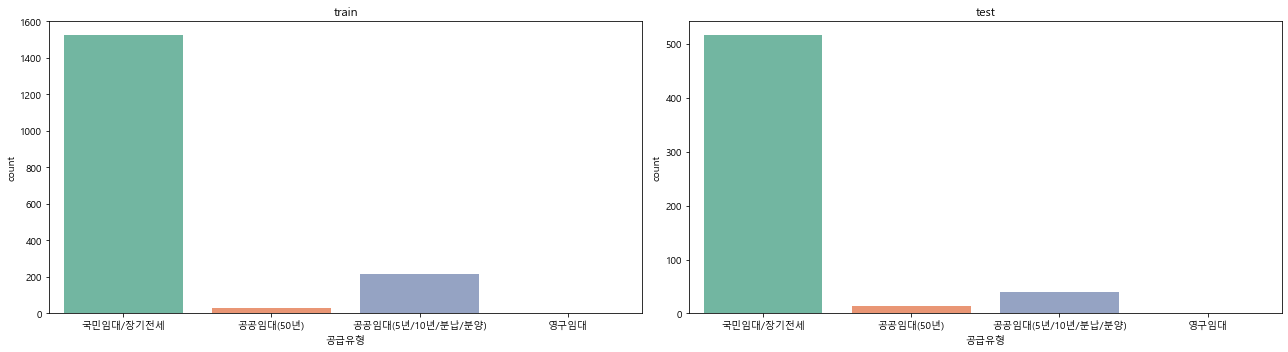

In [67]:
dual_countplot(col='공급유형', 
               train=train.loc[train.자격유형.isin(['A']), ], 
               test=test.loc[test.자격유형.isin(['A']), ],
               figsize=(18,5),flip=False)

2) 자격유형이 B, E, G, H인 공급유형
- E 국민임대/장기전세 또는 영구임대
- 그 외는 영구임대

※ test set에는 공급유형 B 존재 X

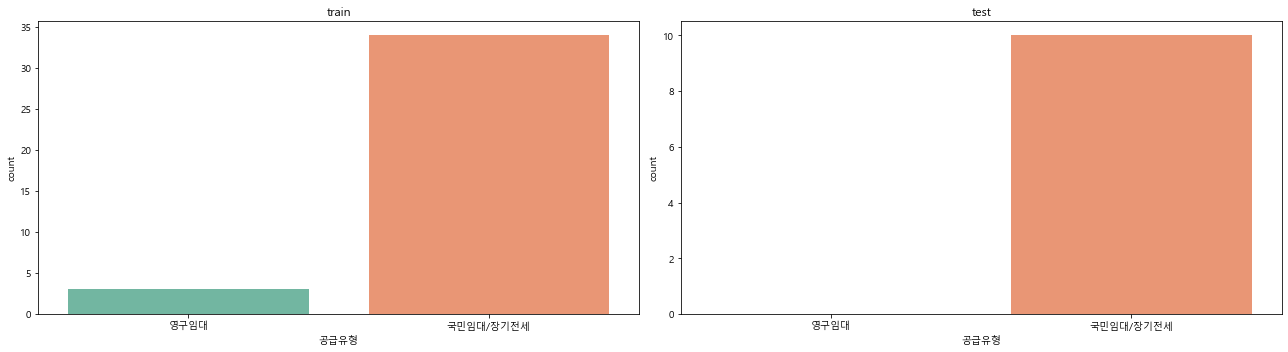

In [68]:
type = "E"
dual_countplot(col='공급유형', 
               train=train.loc[train.자격유형.isin([type]), ], 
               test=test.loc[test.자격유형.isin([type]), ],
               figsize=(18,5),flip=False)

3) 자격유형이 C, F, I인 공급유형
- 전부 영구임대


※ test set에는 공급유형 F 존재 X

4) 자격유형이 D인 공급유형
- 임대상가 또는 공공임대(5년/10년/분납/분양)

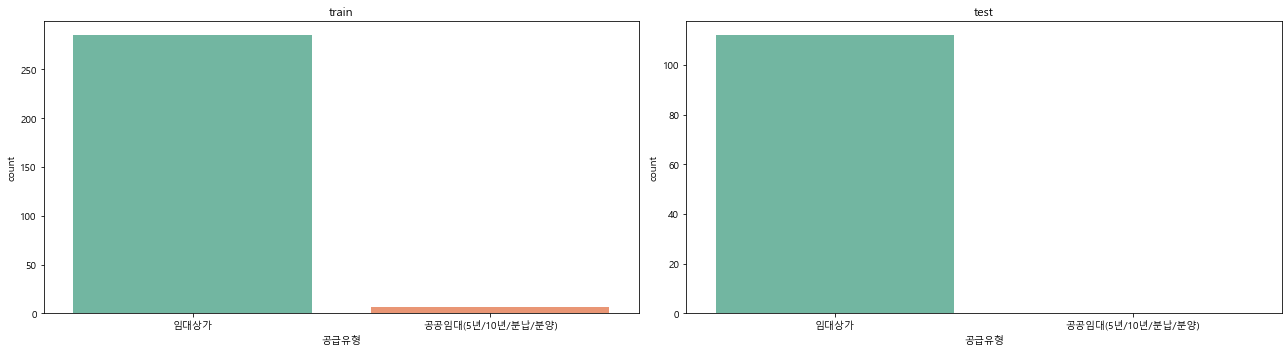

In [69]:
type = "D"
dual_countplot(col='공급유형', 
               train=train.loc[train.자격유형.isin([type]), ], 
               test=test.loc[test.자격유형.isin([type]), ],
               figsize=(18,5),flip=False)

5) 자격유형이 J, K, L, M, N, O인 공급유형
- 전부 행복주택

※ test set에는 공급유형 O 존재 X

In [70]:
dic = {'1': 'A' ,'2':['B','E','G','H'],'3':['C','F','I'],'4':'D','5':['J','K','L','M','N','O']}

In [71]:
train['자격유형_카테고리'] = train['자격유형'].apply(lambda x : mapping_by_key(dic, x))
train['자격유형_카테고리'] = train['자격유형_카테고리'].astype(object)

- test set

In [72]:
test['자격유형_카테고리'] = test['자격유형'].apply(lambda x : mapping_by_key(dic, x))
test['자격유형_카테고리'] = test['자격유형_카테고리'].astype(object)

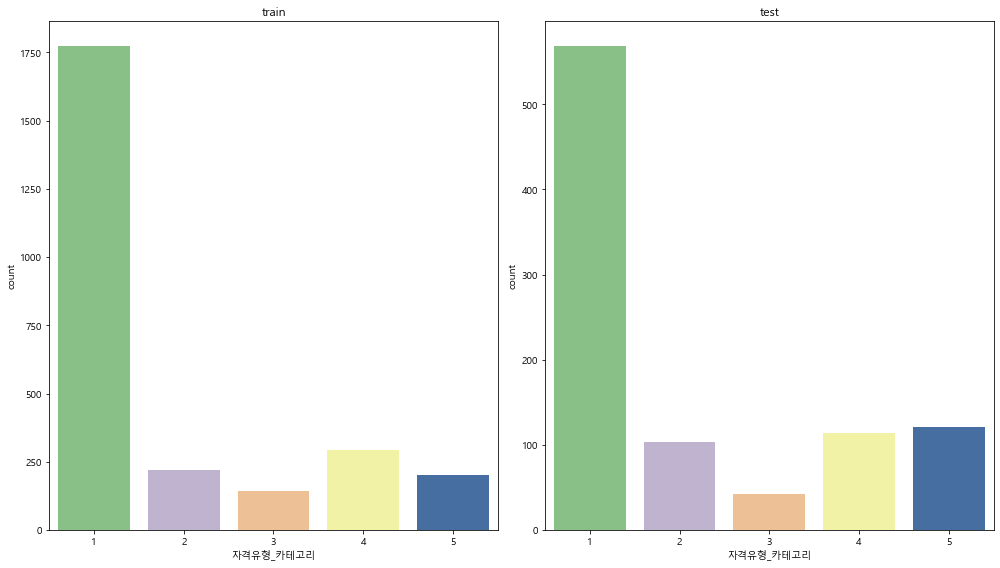

In [73]:
dual_countplot(col='자격유형_카테고리',train=train, test=test, flip=False, pallete="Accent")

#### 공급유형 재범주화(by 유민)
- <font color="red">공공임대(5년), 공공임대(10년), 공공임대(분납) -> 공공임대</font>

◈ [LH공사 공식 홈페이지](https://www.lh.or.kr/contents/cont.do) 기준 주거복지사업
1) 청년·신혼부부계층 임대주택
- 행복주택
2) 주거취약계층 임대주택
- 영구임대
- 매입임대(입주절차의 차이는 있으나 전세임대와 묶어도 생각해도 될 것 같음)
- 전세임대 <br>
: 도심 내 저소득계층 등이 현 생활권에서 거주할 수 있도록 대상자가 거주를 원하는 주택을 물색하면 LH가 전세계약을 체결한 후 저렴하게 재임대하는 공공임대주택 <br>
입주대상 = 쪽방, 고시원, 여인숙, 비닐하우스, 노숙인시설, 컨테이너, 움막, pc방, 만화방에 3개월 이상 거주한 자 및 최저주거기준을 미달하는 주거환경에서 만 18세미만의 자녀와 함께 거주하고 있는 사람 중 거주지 관할 시장ㆍ군수ㆍ구청장이 주거지원이 필요하다고 인정하는 사람 <br>
▶<font color="blue">train set의 장기전세주택과 동일한지는 모르겠음</font>
3) 무주택 서민 임대주택
- 국민임대
- 50년임대
- 5년 분양전환임대주택
- 10년 분양전환임대주택
4) LH 희망상가 <br>
: 일자리창출, 지역경제 활성화, 젠트리피케이션 방지 등 사회적 가치 실현을 위해 청년, 경력단절여성, 소상공인 등에게 장기간 저렴하게 임대하는 LH장기임대주택 단지내 임대상가

◈ 각 공급유형 분석
- **국민임대** <br>
무주택 저소득(소득1∼4분위 계층)의 주거안정을 위해 국가 재정과 국민주택기금을 지원받아 국가, 지방자치단체, 한국토지주택공사 또는 지방공사가 건설, 공급하는 주택이다. 시세 대비 60~80%의 저렴한 임대료에 장기 거주(임대 의무기간 30년)가 가능하지만 해당 주거지를 매입할 수 없다는 단점이 있다. 주거 복지 개념이 들어있기 때문에 소득 및 재산 기준을 충족해야 하는 등 입주 조건이 공공임대에 비해 까다롭다.

- **공공임대(5년, 10년, 분납)** <br>
일반 국민의 주거 수요를 충족하고자 국가 주도로 공급하는 주택이다. 임대의무기간(5년·10년) 동안 임대한 이후 분양으로 전환하거나, 입주 전에 초기분납금을 납부하고 입주 후에 단계적으로 잔여분납금을 납부하다가(분납) 임대 종료 후 분양으로 전환하는 방식이 있다.

- **공공임대(50년)** <br>
50년간 분양 전환하지 않고, 임대로만 거주할 수 있는 공공임대주택을 의미한다.

- **영구임대** <br>
임대료가 시세대비 30% 수준인 사회복지적 성격의 공공임대주택이다. 정부의 재정보조를 받아 생계·의료급여 수급자, 국가유공자, 일본군 위안부 피해자 등의 입주자격을 충족하는 무주택 시민을 대상으로 한다. 최장 50년까지 거주 가능하다.

- **[장기전세](https://www.seoulhousing.kr/html/0101007.do)** <br>
국가, 지자체에서 임대를 목적으로 공급하는 분양불가 주택을 의미한다. 최장 20년까지 거주 가능하다. 영구임대주택의 입주대상 자산기준(총자산 20,000만원)을 충족하는 무주택 시민을 대상으로 한다.

- **행복주택** <br>
기존 장기임대주택과 유사하나 공공 유호지 등을 활용해 사업비를 낮추었기 때문에 비교적 저렴하다. 주로 대학생, 사회초년생, 신혼부부를 대상으로 한다.

- **공공분양** <br>
주택 구입대금을 납부하고 소유권을 취득하는 주택이다.

- **임대상가** <br>
상가만 있는 단지는 없는 것으로 보아 아파트 단지 내 상가로 추측된다. <br>
▶<font color="blue">혹시 LH 희망상가는 아닐까?</font> 

상가가 있는 단지에 위치한 아파트들의 공급유형이 장기임대주택이므로 해당 단지의 상가는 LH 희망상가로 볼 수 있음

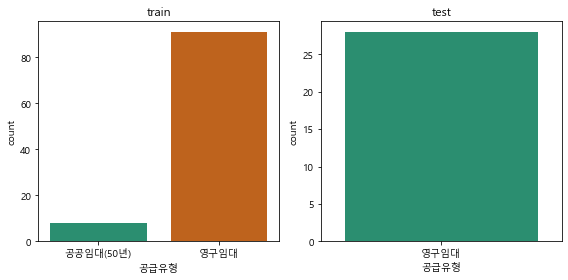

In [171]:
tmp1 = train.loc[(train.단지코드.isin(train.loc[train.임대건물구분=="상가","단지코드"]))&(train.임대건물구분=="아파트"),:]
tmp2 = test.loc[(test.단지코드.isin(test.loc[test.임대건물구분=="상가","단지코드"]))&(test.임대건물구분=="아파트"),:]
dual_countplot(col="공급유형", train=tmp1, test=tmp2, figsize=(8,4), flip=False, pallete="Dark2")

In [200]:
print(*set(train.공급유형), sep=" ")
print(*set(test.공급유형), sep=" ")

국민임대 공공임대(10년) 임대상가 공공분양 공공임대(50년) 공공임대(5년) 장기전세 공공임대(분납) 행복주택 영구임대
국민임대 공공임대(10년) 임대상가 공공임대(50년) 공공임대(분납) 행복주택 영구임대


In [201]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(단기)'

In [202]:
print(*set(train.공급유형), sep=" ")
print(*set(test.공급유형), sep=" ")

국민임대 임대상가 공공임대(단기) 공공분양 공공임대(50년) 장기전세 행복주택 영구임대
국민임대 임대상가 공공임대(단기) 공공임대(50년) 행복주택 영구임대


#### 자격유형_카테고리(by 유민)
**공급유형** 기준 7개 범주로 clustering

J K L M N O / A / B / E / G H / C F I / D 

In [199]:
for i in train['자격유형'].unique():
    print(i,train[train['자격유형']==i]['공급유형'].unique())

A ['국민임대' '공공임대(50년)' '공공임대(10년)' '공공임대(분납)' '장기전세' '영구임대' '공공임대(5년)']
B ['국민임대']
C ['영구임대']
D ['임대상가' '공공분양']
E ['영구임대' '국민임대']
F ['영구임대']
G ['국민임대']
H ['국민임대']
I ['영구임대']
J ['행복주택']
K ['행복주택']
L ['행복주택']
M ['행복주택']
N ['행복주택']
O ['행복주택']


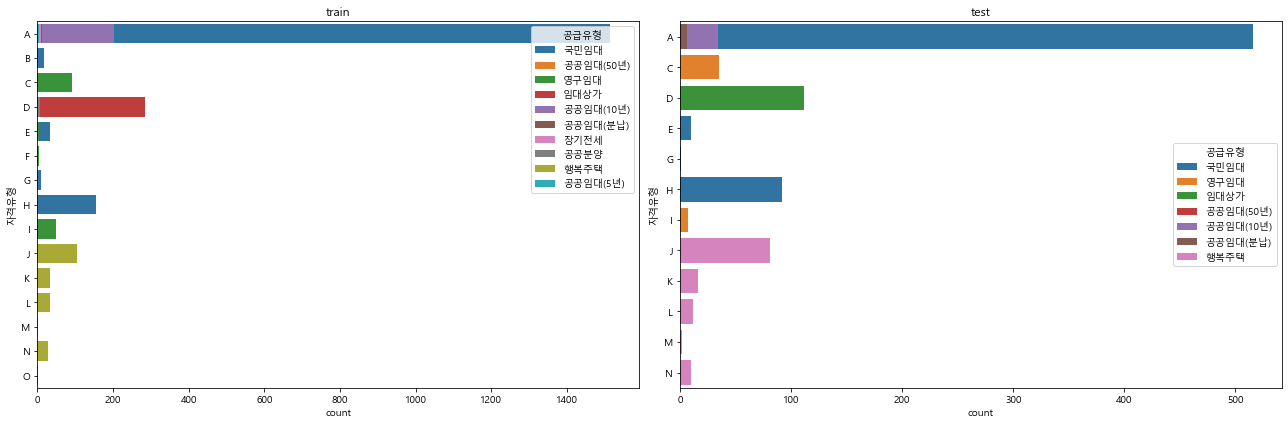

In [190]:
plt.rcParams["figure.figsize"] = (18,6)
fig, ax = plt.subplots(ncols=2)
sns.countplot(data = train, y='자격유형', hue='공급유형', dodge=False, order=sorted(train['자격유형'].unique()), ax=ax[0]).set_title("train")
sns.countplot(data = test, y='자격유형', hue='공급유형', dodge=False, order=sorted(test['자격유형'].unique()), ax=ax[1]).set_title("test")
plt.tight_layout()
plt.show()

In [198]:
print(train.loc[train.임대건물구분=="상가","자격유형"].unique())
print(test.loc[test.임대건물구분=="상가","자격유형"].unique())
print(train.loc[train.자격유형=="D","공급유형"].unique())
print(test.loc[test.자격유형=="D","공급유형"].unique())

['D']
['D']
['임대상가' '공공분양']
['영구임대' '임대상가']


In [209]:
dic = {'1': 'A' ,'2':['G','H'],'3':['C','F','I'],'4':'D','5':['J','K','L','M','N','O'],'6': 'B','7': 'E'}
train['자격유형_카테고리'] = train['자격유형'].apply(lambda x : mapping_by_key(dic, x))
test['자격유형_카테고리'] = test['자격유형'].apply(lambda x : mapping_by_key(dic, x))
train['자격유형_카테고리'] = train['자격유형_카테고리'].astype(object)
test['자격유형_카테고리'] = test['자격유형_카테고리'].astype(object)

**numerical feature**
- 총세대수& 전용면적별세대수
- 전용면적
- 공가수
- 임대료 & 임대보증금
- 지하철역 & 버스정류장
- 단지내주차면수
- 등록차량수

In [68]:
print("numerical features:")
print(*num_col, sep="\n")

numerical features:
총세대수
전용면적
전용면적별세대수
공가수
임대보증금
임대료
지하철역
버스정류장
단지내주차면수
등록차량수


### 총세대수 & 전용면적별세대수
- 전용면적별세대수 = '임대'아파트 
- 총세대수 = '임대'아파트 + '분양'아파트

▶임대아파트가 분양되거나 단지 내 상가가 분양된 경우 전용면적별세대수의 합과 총세대수가 분양된 수만큼 차이가 남

▶분양세대수 column 추가? - X

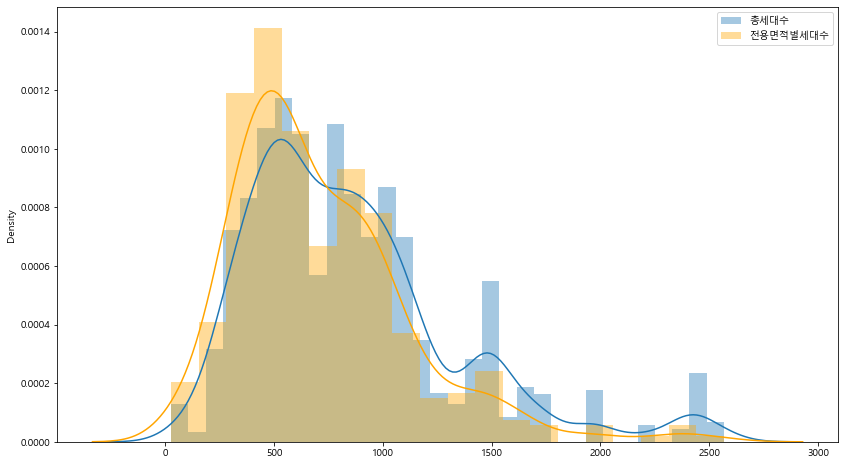

In [104]:
plt.rcParams["figure.figsize"] = (14,8)
sns.distplot(a=train['총세대수'], label='총세대수')
sns.distplot(a=train.groupby(['단지코드']).sum()['전용면적별세대수'], label='전용면적별세대수',color="orange")
plt.xlabel('')
plt.legend()
plt.show()

#### 분양세대수(by 유민)

In [105]:
train_sale = pd.DataFrame(train.groupby(['단지코드']).first()['총세대수'] - train.groupby(['단지코드']).sum()['전용면적별세대수'])
train_sale.columns = ["분양세대수"]
train_sale = train_sale.astype('int16')
train_sale.reset_index(inplace=True)
train_sale

,단지코드,분양세대수
0,C1000,0
1,C1004,4
2,C1005,0
3,C1013,0
4,C1014,0
...,...,...
418,C2663,0
419,C2666,0
420,C2670,0
421,C2680,0


In [106]:
train = pd.merge(train, train_sale,on="단지코드")
train

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역,버스정류장,단지내주차면수,등록차량수,자격유형_카테고리,자격유형1,자격유형2,자격유형3,자격유형4,자격유형5,자격유형6,자격유형7,자격유형8,상가비율,분양세대수
0,C2483,900,아파트,경상북도,국민임대/장기전세,39.7200,134,38.0000,A,"15,667,000.0000","103,680.0000",0.0000,3.0000,"1,425.0000","1,015.0000",1,1,0,0,0,0,0,0,0,0.0000,0
1,C2483,900,아파트,경상북도,국민임대/장기전세,39.7200,15,38.0000,A,"15,667,000.0000","103,680.0000",0.0000,3.0000,"1,425.0000","1,015.0000",1,1,0,0,0,0,0,0,0,0.0000,0
2,C2483,900,아파트,경상북도,국민임대/장기전세,51.9300,385,38.0000,A,"27,304,000.0000","184,330.0000",0.0000,3.0000,"1,425.0000","1,015.0000",1,1,0,0,0,0,0,0,0,0.0000,0
3,C2483,900,아파트,경상북도,국민임대/장기전세,51.9300,15,38.0000,A,"27,304,000.0000","184,330.0000",0.0000,3.0000,"1,425.0000","1,015.0000",1,1,0,0,0,0,0,0,0,0.0000,0
4,C2483,900,아파트,경상북도,국민임대/장기전세,51.9300,41,38.0000,A,"27,304,000.0000","184,330.0000",0.0000,3.0000,"1,425.0000","1,015.0000",1,1,0,0,0,0,0,0,0,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2627,C2532,239,아파트,강원도,국민임대/장기전세,49.2000,19,7.0000,A,"11,346,000.0000","116,090.0000",0.0000,1.0000,166.0000,146.0000,1,1,0,0,0,0,0,0,0,0.0000,0
2628,C2532,239,아파트,강원도,국민임대/장기전세,51.0800,34,7.0000,A,"14,005,000.0000","142,310.0000",0.0000,1.0000,166.0000,146.0000,1,1,0,0,0,0,0,0,0,0.0000,0
2629,C2532,239,아파트,강원도,국민임대/장기전세,51.7300,34,7.0000,A,"14,005,000.0000","142,310.0000",0.0000,1.0000,166.0000,146.0000,1,1,0,0,0,0,0,0,0,0.0000,0
2630,C2532,239,아파트,강원도,국민임대/장기전세,51.9600,114,7.0000,A,"14,005,000.0000","142,310.0000",0.0000,1.0000,166.0000,146.0000,1,1,0,0,0,0,0,0,0,0.0000,0


- C1024 단지의 분양 세대수는 203세대로 임대아파트가 분양된 case
- C1004 단지의 분양 세대수는 4세대로 단지내 상가 or 임대아파트가 분양된 case

In [107]:
train.loc[train.분양세대수>0,['단지코드','총세대수','분양세대수','상가비율']].groupby(['단지코드']).first().head()

,총세대수,분양세대수,상가비율
단지코드,,,
C1004,521,4,0.8667
C1024,680,203,0.0000
C1056,410,9,0.3333
C1068,806,1,0.0000
C1109,1957,5,0.8824


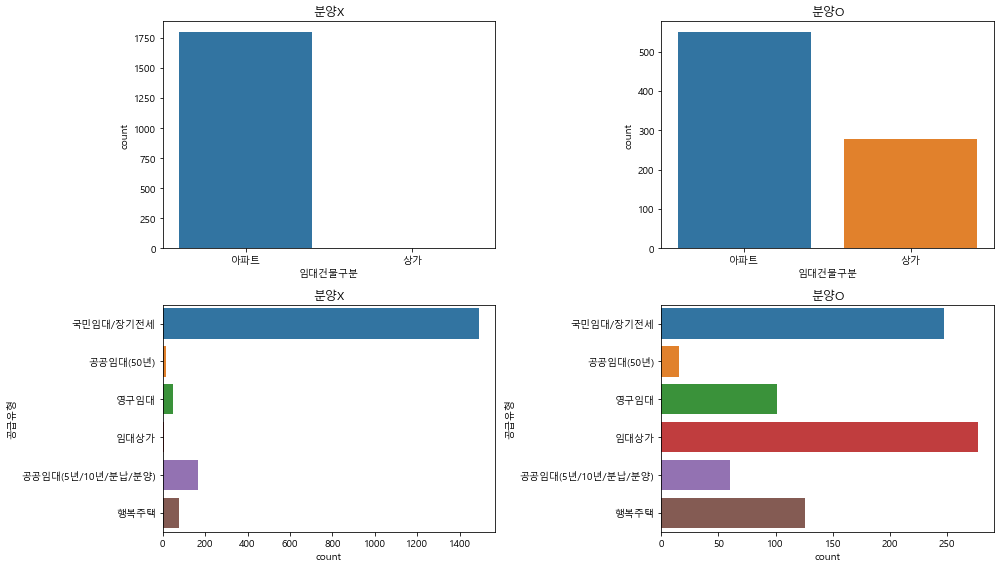

In [108]:
plt.rcParams["figure.figsize"] = (14,8)
fig, ax = plt.subplots(ncols=2,nrows=2)
sns.countplot(train.loc[train.분양세대수==0,'임대건물구분'], ax=ax[0,0]).set_title("분양X")
sns.countplot(train.loc[train.분양세대수>0,'임대건물구분'], ax=ax[0,1]).set_title("분양O")
sns.countplot(data=train.loc[train.분양세대수==0,],y='공급유형',ax=ax[1,0],order=train['공급유형'].unique()).set_title("분양X")
sns.countplot(data=train.loc[train.분양세대수>0,],y='공급유형',ax=ax[1,1],order=train['공급유형'].unique()).set_title("분양O")
plt.tight_layout()
plt.show()

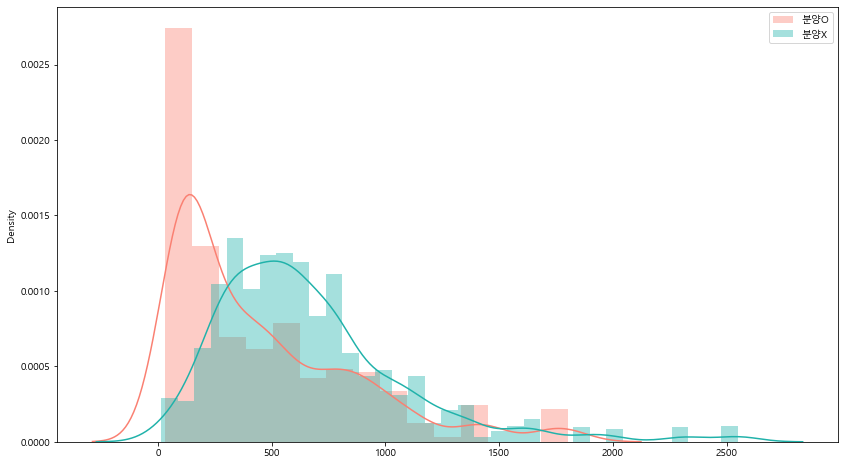

In [109]:
plt.rcParams["figure.figsize"] = (14,8)
sns.distplot(train.loc[train.분양세대수>0,"등록차량수"], label="분양O", color="salmon")
sns.distplot(train.loc[train.분양세대수==0,"등록차량수"], label="분양X", color="lightseagreen")
plt.xlabel('')
plt.legend()
plt.show()

In [110]:
# del train['분양세대수']

### 전용면적
주택법상 주택건설기준에 따라 전용면적 85㎡ 이하 1가구당 주차장 1면을 설치해야 함 <br>
대형 면적인 85㎡ 초과 세대의 경우 전용면적 기준은 70㎡당 1면

▶<font color="red">대형전용면적 column 추가</font> <br>

▶<font color="red">전용면적_카테고리 column 추가</font> 

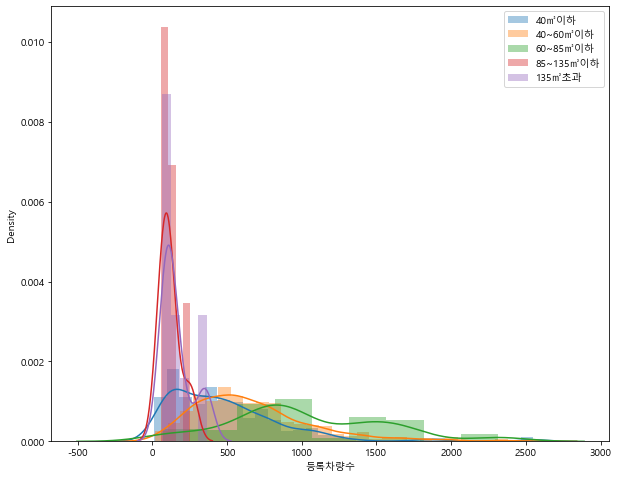

In [120]:
plt.rcParams["figure.figsize"] = (10,8)
sns.distplot(train.loc[train.전용면적<=40,'등록차량수'],label="40㎡이하")
sns.distplot(train.loc[(train.전용면적>40)&(train.전용면적<=60),'등록차량수'],label="40~60㎡이하")
sns.distplot(train.loc[(train.전용면적>60)&(train.전용면적<=85),'등록차량수'],label="60~85㎡이하")
sns.distplot(train.loc[(train.전용면적>85)&(train.전용면적<=135),'등록차량수'],label="85~135㎡이하")
sns.distplot(train.loc[(train.전용면적>135),'등록차량수'],label="135㎡초과")
plt.legend()
plt.show()

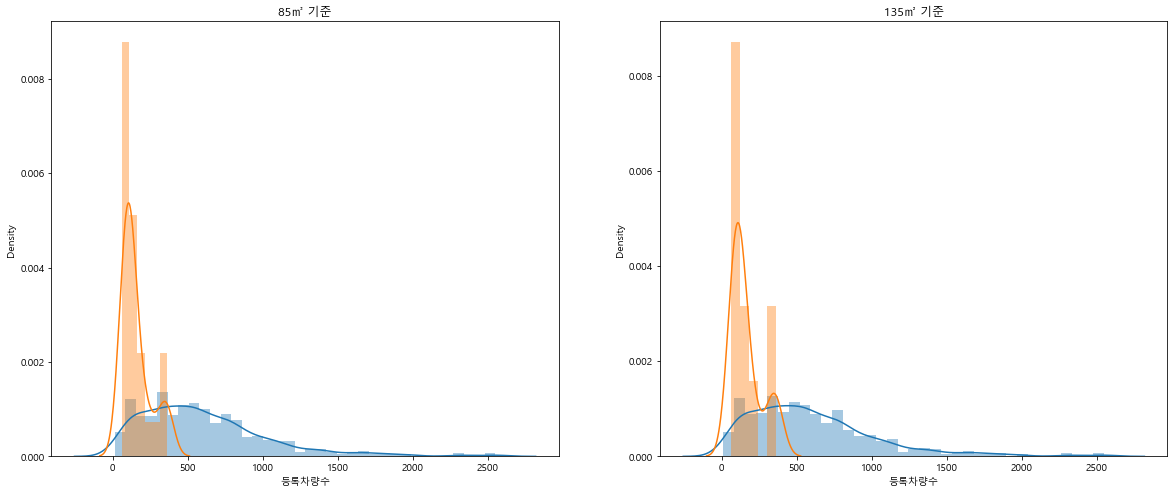

In [121]:
plt.rcParams["figure.figsize"] = (20,8)
fig, ax = plt.subplots(ncols=2)
level = 85
sns.distplot(train.loc[train.전용면적<=level,'등록차량수'], ax=ax[0]).set_title(f"{level}㎡ 기준")
sns.distplot(train.loc[train.전용면적>level,'등록차량수'], ax=ax[0])

level = 135
sns.distplot(train.loc[train.전용면적<=level,'등록차량수'], ax=ax[1]).set_title(f"{level}㎡ 기준")
sns.distplot(train.loc[train.전용면적>level,'등록차량수'], ax=ax[1])
plt.show()

#### 대형전용면적
85㎡를 초과하는 건물은 대형건물로 분류

- train set

In [122]:
level = 85
train['대형전용면적'] = 0
train.loc[train.전용면적>level, '대형전용면적'] = 1
train.loc[train.전용면적<=level, '대형전용면적'] = 0

- test set

In [123]:
level = 85
test['대형전용면적'] = 0
test.loc[test.전용면적>level, '대형전용면적'] = 1
test.loc[test.전용면적<=level, '대형전용면적'] = 0

#### 전용면적_카테고리(사용 X)
100㎡를 초과하는 건물은 outlier로 간주 & 10㎡ 단위로 범주화
- train set

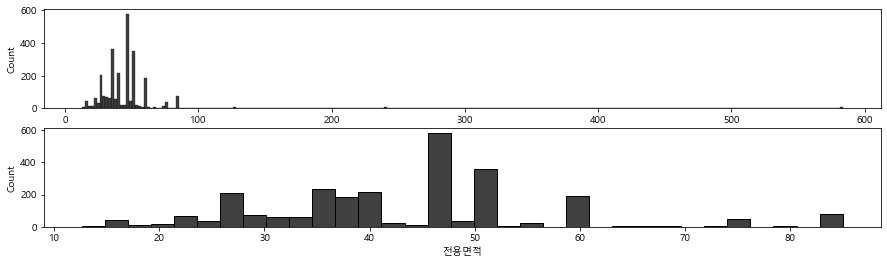

In [124]:
tmp = train[train['전용면적']<100]
plt.rcParams["figure.figsize"] = (10,8)
fig,ax = plt.subplots(2,1,figsize=(15,4))
sns.histplot(data=train, x='전용면적',color='black',ax=ax[0])
sns.histplot(data=tmp,x='전용면적',color='black',ax=ax[1])
plt.show()

In [106]:
train[train['전용면적']<100].groupby('단지코드').std()['전용면적'].mean()

6.94063913683481

In [107]:
def category(x):
    for ind,i in enumerate(list(range(10,110,5))): #0부터 100까지 10단위
        if int(x) in range(i-10,i): return ind
    for ind,i in enumerate(list(range(100,600,100))):#100부터 600까지 100단위
        if int(x) in range(i,i+100): return 10+ind

In [108]:
train['전용면적_카테고리'] = train['전용면적'].apply(lambda x : category(x))
train['전용면적_카테고리'].unique()

array([ 6,  9, 10,  5,  8,  7,  4, 13,  1,  2,  3, 12, 11, 14, 15],
      dtype=int64)

In [109]:
train.loc[train.전용면적_카테고리==12,['전용면적_카테고리','단지코드','전용면적']]

,전용면적_카테고리,단지코드,전용면적
140,12,C2416,317.1700
2324,12,C1743,67.8600
2325,12,C1743,67.8600
2326,12,C1743,67.8800
2327,12,C1743,67.8800
2416,12,C1933,66.8500
2417,12,C1933,66.9400
2419,12,C1933,66.9600
2430,12,C2051,65.3900


In [110]:
for i in train['전용면적_카테고리']:
    train['전용면적'+str(i)] = 0

In [111]:
sample = pd.DataFrame(train.groupby('단지코드')['전용면적_카테고리'].unique()).reset_index()
sample.head()

,단지코드,전용면적_카테고리
0,C1000,"[6, 8, 9]"
1,C1004,"[6, 2, 1, 3, 4, 5, 9, 11]"
2,C1005,"[9, 10]"
3,C1013,"[6, 8, 9]"
4,C1014,"[5, 8, 9, 10]"


In [112]:
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val = sample.loc[i,'전용면적_카테고리']
    ind = train[train['단지코드']==code].index
    for j in val:
        train.loc[ind,'전용면적'+str(j)] = 1

- test set

In [113]:
test['전용면적_카테고리'] = test['전용면적'].apply(lambda x : category(x))
for i in test['전용면적_카테고리']:
    test['전용면적'+str(i)] = 0
sample = pd.DataFrame(test.groupby('단지코드')['전용면적_카테고리'].unique()).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    val = sample.loc[i,'전용면적_카테고리']
    ind = test[test['단지코드']==code].index
    for j in val:
        test.loc[ind,'전용면적'+str(j)] = 1

### 공가수
총세대수에 공가수가 포함되는지 불확실함 <br>
- 데이콘 질의응답 참고
[Dacon F&Q](https://dacon.io/competitions/open/235745/support/403630?page=1&dtype=recent)

▶<font color="red">분양비율 column 추가</font> 

#### 분양비율 / 분양세대수(by 유림)
▶(총세대수-공가수)/총세대수

<font color="blue">※ Dacon 측에서 언급한 분양세대수(전용면적별세대수와 총세대수의 차)와 값이 다르지만 일단 추가</font>

In [116]:
train['분양비율']= (train.총세대수-train.공가수)/train.총세대수 
test['분양비율']= (test.총세대수-test.공가수)/test.총세대수 

In [117]:
pd.DataFrame({'단지코드':train.단지코드, '분양세대수_유민':train.분양세대수,
             '분양세대수_은영':train['분양비율']*train['총세대수'],
              '총세대수':train.총세대수,
              '공가수':train.공가수,
              '전용면적별세대수':train.전용면적별세대수})

,단지코드,분양세대수_유민,분양세대수_은영,총세대수,공가수,전용면적별세대수
0,C2483,0,862.0000,900,38.0000,134
1,C2483,0,862.0000,900,38.0000,15
2,C2483,0,862.0000,900,38.0000,385
3,C2483,0,862.0000,900,38.0000,15
4,C2483,0,862.0000,900,38.0000,41
...,...,...,...,...,...,...
2627,C2532,0,232.0000,239,7.0000,19
2628,C2532,0,232.0000,239,7.0000,34
2629,C2532,0,232.0000,239,7.0000,34
2630,C2532,0,232.0000,239,7.0000,114


In [118]:
train.drop(['단지코드'],1,).corr()["등록차량수"].abs().sort_values(ascending=False)

등록차량수        1.0000
단지내주차면수      0.8513
세대당_가능주차면수   0.5131
임대료          0.4617
총세대수         0.4237
자격유형7        0.4042
상가비율         0.4031
임대보증금        0.3824
자격유형8        0.3542
자격유형1        0.3065
분양비율         0.2493
전용면적별세대수     0.1889
자격유형2        0.1550
자격유형6        0.1347
자격유형4        0.1260
버스정류장        0.1193
분양세대수        0.1047
공가수          0.0955
자격유형5        0.0813
전용면적         0.0811
지하철역         0.0778
자격유형3        0.0612
Name: 등록차량수, dtype: float64

In [119]:
train.drop(['단지코드'],1,).corr()["총세대수"].abs().sort_values(ascending=False)

총세대수         1.0000
단지내주차면수      0.5983
등록차량수        0.4237
분양비율         0.4233
상가비율         0.3732
자격유형3        0.3550
자격유형8        0.3483
자격유형7        0.3387
자격유형1        0.3030
세대당_가능주차면수   0.2323
자격유형2        0.1819
전용면적별세대수     0.1682
자격유형4        0.1530
지하철역         0.1365
공가수          0.1032
분양세대수        0.0986
자격유형6        0.0885
전용면적         0.0675
버스정류장        0.0373
임대보증금        0.0260
자격유형5        0.0132
임대료          0.0002
Name: 총세대수, dtype: float64

### 임대료 & 임대보증금 
▶ train set에서 임대보증금만 NA인 건물은 9개 <br>
그 외에는 임대료 & 임대보증금 모두 NA

▶ test set에서 임대료가 NA인 건물은 임대보증금이 NA인 건물과 동일

▶ <font color="red">공공분양은 0으로 대체</font> 

▶ 지역별 가중치 <br>
ex: 강원도같은 경우는 평균치를 넣고 서울은 이것의 1.5배로 설정

In [84]:
check_NA(train)
check_NA(test)

NA check
임대보증금 304 -> 11.55 %
임대료 313 -> 11.892 %
지하철역 155 -> 5.889 %
버스정류장 4 -> 0.152 %
NA check
임대보증금 120 -> 12.645 %
임대료 120 -> 12.645 %
지하철역 34 -> 3.583 %


In [85]:
sum(test.loc[test.임대료.isna(),:].index!=test.loc[test.임대보증금.isna(),:].index)

0

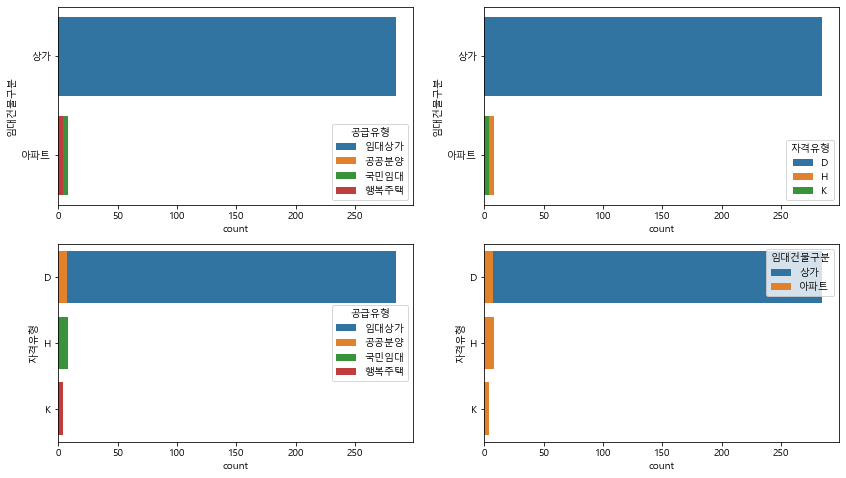

In [104]:
# train: 임대료와 임대보증금이 NA인 건물
tmp = train.loc[(train.임대료.isna())&(train.임대보증금.isna()),:]
plt.rcParams["figure.figsize"] = (14,8)
fig, ax = plt.subplots(ncols=2, nrows=2)
sns.countplot(y='임대건물구분', hue='공급유형', data=tmp, dodge=False, ax=ax[0,0])
sns.countplot(y='임대건물구분', hue='자격유형', data=tmp, dodge=False, ax=ax[0,1])
sns.countplot(y='자격유형', hue='공급유형', data=tmp, dodge=False, ax=ax[1,0])
sns.countplot(y='자격유형', hue='임대건물구분', data=tmp, dodge=False, ax=ax[1,1])
plt.show()

In [87]:
# # train: 임대보증금만 NA인 건물
# tmp = train.loc[(train.임대료.isna())&(~train.임대보증금.isna()),:]
# plt.rcParams["figure.figsize"] = (14,8)
# fig, ax = plt.subplots(ncols=2, nrows=2)
# sns.countplot(y='임대건물구분', hue='공급유형', data=tmp, dodge=False, ax=ax[0,0])
# sns.countplot(y='임대건물구분', hue='자격유형', data=tmp, dodge=False, ax=ax[0,1])
# sns.countplot(y='자격유형', hue='공급유형', data=tmp, dodge=False, ax=ax[1,0])
# sns.countplot(y='자격유형', hue='임대건물구분', data=tmp, dodge=False, ax=ax[1,1])
# plt.show()

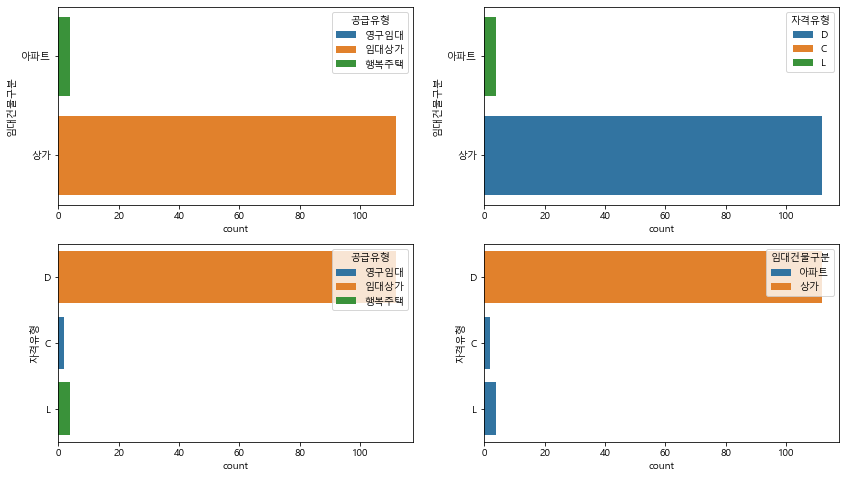

In [88]:
# test: 임대료와 임대보증금이 NA인 건물
tmp = test.loc[test.임대보증금.isna(),]
plt.rcParams["figure.figsize"] = (14,8)
fig, ax = plt.subplots(ncols=2, nrows=2)
sns.countplot(y='임대건물구분', hue='공급유형', data=tmp, dodge=False, ax=ax[0,0])
sns.countplot(y='임대건물구분', hue='자격유형', data=tmp, dodge=False, ax=ax[0,1])
sns.countplot(y='자격유형', hue='공급유형', data=tmp, dodge=False, ax=ax[1,0])
sns.countplot(y='자격유형', hue='임대건물구분', data=tmp, dodge=False, ax=ax[1,1])
plt.show()

#### NA imputation
▶ 공공분양은 0으로 대체

In [89]:
train.loc[(train.임대료.isna())&(train.공급유형=="공공분양"),'임대료'] = 0
train.loc[(train.임대보증금.isna())&(train.공급유형=="공공분양"),'임대보증금'] = 0

▶ 동일한 단지코드인 아파트 임대료, 임대보증금 평균 값을 사용해서 NA imputation

cf.) 다른 외부 데이터를 이용해서 주상복합에 속한 아파트, 상가의 보증금 관계를 살펴보는 것도 하나의 방법

- train set

**Step 1. 단지코드별 평균으로 대체<font>**

In [90]:
check_NA(train)

NA check
임대보증금 304 -> 11.55 %
임대료 313 -> 11.892 %
지하철역 155 -> 5.889 %
버스정류장 4 -> 0.152 %


In [91]:
# 임대료 NA impute
train = impute_by_code(train, '임대료')

임대료에 NA가 있는 단지코드: ['C1925' 'C1874' 'C2416' 'C2621' 'C1616' 'C1704' 'C2258' 'C2038' 'C1859'
 'C1722' 'C2190' 'C1476' 'C1983' 'C2135' 'C2034' 'C1109' 'C2289' 'C2597'
 'C2310' 'C2132' 'C1439' 'C1899' 'C1056' 'C2644' 'C1206' 'C1775' 'C1790'
 'C2109' 'C1698' 'C1004' 'C1875' 'C2212' 'C2571' 'C1397' 'C1039' 'C1350'
 'C1326' 'C1786' 'C2186']
임대료이(가) 모두 NA인 단지코드:
C1397
C1326


In [92]:
# 임대보증금 NA impute
train = impute_by_code(train, '임대보증금')

임대보증금에 NA가 있는 단지코드: ['C1925' 'C1874' 'C2416' 'C2621' 'C1616' 'C1704' 'C2258' 'C2038' 'C1859'
 'C1722' 'C2190' 'C1476' 'C1983' 'C2135' 'C2034' 'C1109' 'C2289' 'C2597'
 'C2310' 'C2132' 'C1439' 'C1899' 'C1056' 'C2644' 'C1206' 'C1775' 'C1790'
 'C2109' 'C1698' 'C1004' 'C1875' 'C2212' 'C2571' 'C1350' 'C1326' 'C1786'
 'C2186']
임대보증금이(가) 모두 NA인 단지코드:
C1326


In [93]:
check_NA(train)

NA check
임대보증금 5 -> 0.19 %
임대료 11 -> 0.418 %
지하철역 155 -> 5.889 %
버스정류장 4 -> 0.152 %


**Step2. 모두 NA인 경우 해당 단지코드의 지역과 공급유형이 동일한 단지코드의 평균으로 대체**

In [94]:
train[train['단지코드']=='C1326'][['지역','공급유형']].values[0]

array(['부산광역시', '국민임대/장기전세'], dtype=object)

In [95]:
train[train['단지코드']=='C1397'][['지역','공급유형']].values[0]

array(['서울특별시', '국민임대/장기전세'], dtype=object)

In [96]:
# C1326
m = train[(train['지역']=='서울특별시')&(train['공급유형']=='장기전세')&(train['임대료'].isna()==False)]['임대료'].values.mean()
train.loc[train['단지코드']=='C1397','임대료'] = m
# C1397
m1 = train[(train['지역']=='부산광역시')&(train['공급유형']=='국민임대')&(train['임대료'].isna()==False)]['임대료'].values.mean()
m2 = train[(train['지역']=='부산광역시')&(train['공급유형']=='국민임대')&(train['임대보증금'].isna()==False)]['임대보증금'].values.mean()
train.loc[train['단지코드']=='C1326','임대료'] = m1
train.loc[train['단지코드']=='C1326','임대보증금'] = m2

In [97]:
check_NA(train)

NA check
임대보증금 5 -> 0.19 %
임대료 11 -> 0.418 %
지하철역 155 -> 5.889 %
버스정류장 4 -> 0.152 %


- test set

In [98]:
check_NA(test)

NA check
임대보증금 120 -> 12.645 %
임대료 120 -> 12.645 %
지하철역 34 -> 3.583 %


In [99]:
# 임대료 NA impute
test = impute_by_code(test, '임대료')

임대료에 NA가 있는 단지코드: ['C1006' 'C2676' 'C2177' 'C2033' 'C1812' 'C2253' 'C1729' 'C2152' 'C1267']
임대료이(가) 모두 NA인 단지코드:
C2152


In [100]:
# 임대보증금 NA impute
test = impute_by_code(test, '임대보증금')

임대보증금에 NA가 있는 단지코드: ['C1006' 'C2676' 'C2177' 'C2033' 'C1812' 'C2253' 'C1729' 'C2152' 'C1267']
임대보증금이(가) 모두 NA인 단지코드:
C2152


In [101]:
test[test['단지코드']=='C2152'][['지역','공급유형']].values[0]

array(['강원도', '영구임대'], dtype=object)

In [102]:
# C2152
m = test[(test['지역']=='강원도')&(test['공급유형']=='영구임대')&(test['임대료'].isna()==False)]['임대료'].values.mean()
test.loc[test['단지코드']=='C2152','임대료'] = m
test.loc[test['단지코드']=='C2152','임대보증금'] = m

In [103]:
check_NA(test)

NA check
지하철역 34 -> 3.583 %


### 지하철역 & 버스정류장
▶ <font color="red">그냥 0으로 대체?</font>

▶ 충청남도, 경상남도는 모두 0으로 채우고 대전은 생각해볼 것

In [133]:
check_NA(train)
check_NA(test)

NA check
임대보증금 5 -> 0.19 %
임대료 11 -> 0.418 %
지하철역 155 -> 5.889 %
버스정류장 4 -> 0.152 %
NA check
지하철역 34 -> 3.583 %


In [134]:
print(train.loc[train.지하철역.isna(),'지역'].value_counts())

충청남도     82
대전광역시    69
경상남도      4
Name: 지역, dtype: int64


In [135]:
print(train.loc[train.버스정류장.isna(),'지역'].value_counts())

경상남도    4
Name: 지역, dtype: int64


#### NA imputation
**우선 0으로 대체**

In [136]:
cols = ['지하철역','버스정류장']
train[cols] = train[cols].fillna(0)
test[cols] = test[cols].fillna(0)

In [137]:
check_NA(train)
check_NA(test)

NA check
임대보증금 5 -> 0.19 %
임대료 11 -> 0.418 %
NA check
...There's no NA


### 단지내주차면수
target과의 correlation이 높은 변수

▶ <font color="red">세대당_가능주차면수 column 추가</font>

In [111]:
train.corr()["등록차량수"].abs().sort_values(ascending=False)

등록차량수      1.0000
단지내주차면수    0.8513
임대료        0.4617
총세대수       0.4237
자격유형7      0.4042
상가비율       0.4031
임대보증금      0.3824
자격유형8      0.3542
자격유형1      0.3065
전용면적별세대수   0.1889
자격유형2      0.1550
자격유형6      0.1347
자격유형4      0.1260
버스정류장      0.1193
분양세대수      0.1047
공가수        0.0955
자격유형5      0.0813
전용면적       0.0811
지하철역       0.0778
자격유형3      0.0612
Name: 등록차량수, dtype: float64

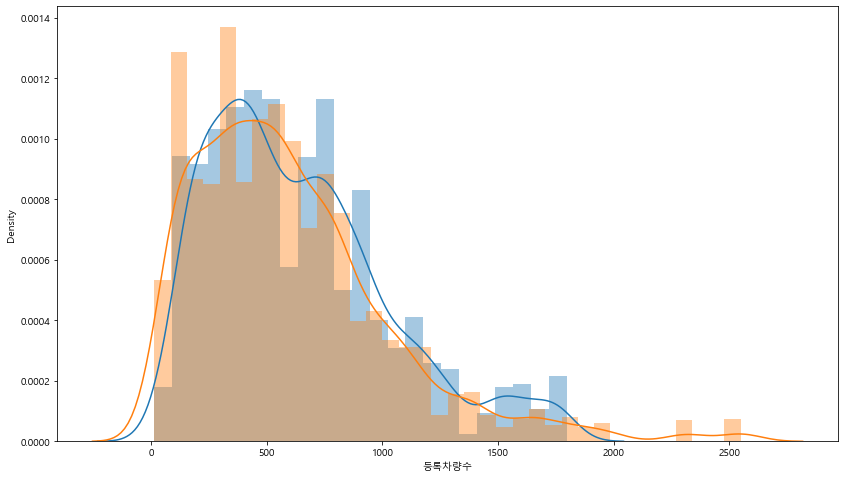

In [112]:
plt.rcParams["figure.figsize"] = (14,8)
sns.distplot(train['단지내주차면수'])
sns.distplot(train['등록차량수'])
plt.show()

#### 세대당_가능주차면수
- 임대주택 만들 때 세대수를 정하고서 주차면수가 정해지는 것이라고 합니다. 
- 그래서 1세대당 주차면수가 얼마나 가능한지를 나타낼 수 있는 주차면수/총세대수가 더 의미있을 것 같음.  

In [113]:
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']

In [114]:
train.drop(['단지코드'],1,).corr()["등록차량수"].abs().sort_values(ascending=False)

등록차량수        1.0000
단지내주차면수      0.8513
세대당_가능주차면수   0.5131
임대료          0.4617
총세대수         0.4237
자격유형7        0.4042
상가비율         0.4031
임대보증금        0.3824
자격유형8        0.3542
자격유형1        0.3065
전용면적별세대수     0.1889
자격유형2        0.1550
자격유형6        0.1347
자격유형4        0.1260
버스정류장        0.1193
분양세대수        0.1047
공가수          0.0955
자격유형5        0.0813
전용면적         0.0811
지하철역         0.0778
자격유형3        0.0612
Name: 등록차량수, dtype: float64

In [115]:
test.drop(['단지코드'],1,).corr()["단지내주차면수"].abs().sort_values(ascending=False)

단지내주차면수      1.0000
총세대수         0.4745
자격유형1        0.4299
세대당_가능주차면수   0.4146
임대료          0.4004
자격유형7        0.3876
자격유형8        0.3545
상가비율         0.3467
임대보증금        0.3350
전용면적별세대수     0.3124
공가수          0.2896
자격유형2        0.2675
자격유형6        0.2520
버스정류장        0.1595
자격유형4        0.1116
지하철역         0.0705
자격유형5        0.0641
전용면적         0.0371
자격유형3           NaN
Name: 단지내주차면수, dtype: float64

### 등록차량수 - target

In [138]:
train['등록차량수'].describe()

count   2,632.0000
mean      600.8431
std       431.6307
min        13.0000
25%       296.0000
50%       520.0000
75%       795.0000
max     2,550.0000
Name: 등록차량수, dtype: float64

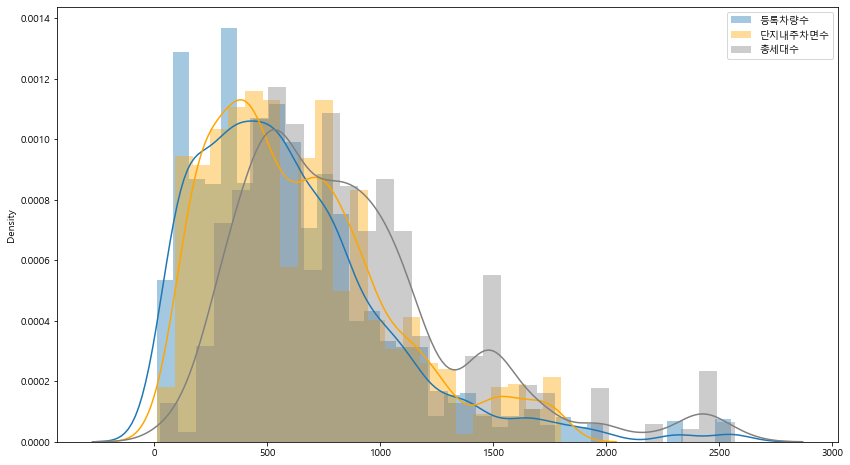

In [139]:
plt.rcParams["figure.figsize"] = (14,8)
sns.distplot(a=train['등록차량수'], label='등록차량수')
sns.distplot(a=train['단지내주차면수'], label='단지내주차면수',color="orange")
sns.distplot(a=train['총세대수'], hist = True, label='총세대수',color="gray")
plt.xlabel('')
plt.legend()
plt.show()

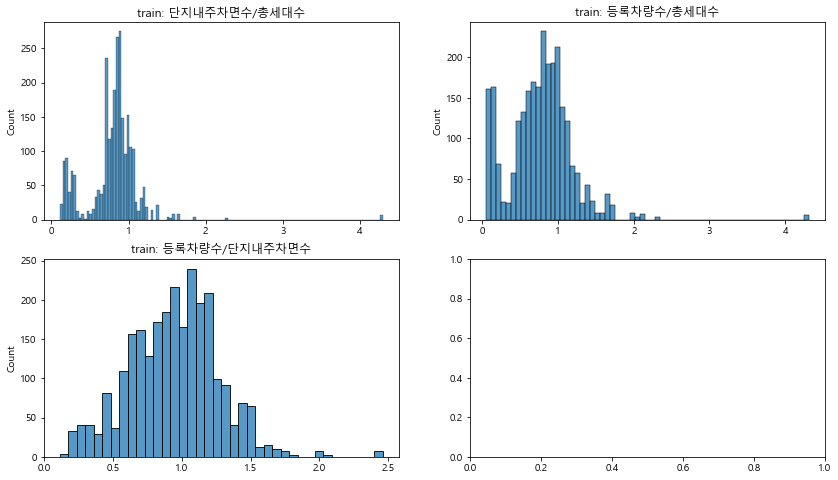

In [140]:
plt.rcParams["figure.figsize"] = (14,8)
fig, ax = plt.subplots(ncols=2, nrows=2)
sns.histplot(train.단지내주차면수/train.총세대수, ax=ax[0,0]).set_title("train: 단지내주차면수/총세대수")
sns.histplot(train.등록차량수/train.총세대수, ax=ax[0,1]).set_title("train: 등록차량수/총세대수")
sns.histplot(train.등록차량수/train.단지내주차면수, ax=ax[1,0]).set_title("train: 등록차량수/단지내주차면수")
# sns.histplot(test.단지내주차면수/test.총세대수, ax=ax[1,0]).set_title("test: 단지내주차면수/총세대수")
# sns.histplot(test.등록차량수/test.총세대수, ax=ax[1,1]).set_title("test: 등록차량수/총세대수")
plt.show()

# Preprocess(EDA 건너뛰고 바로 전처리)
cf.) function 코드 블럭만 실행한 뒤에 하단 코드 블럭 실행하면 됨

In [115]:
# load data & duplicates 제거
filepath = "./data"
train = read_file(os.path.join(filepath,'train.csv'))
test = read_file(os.path.join(filepath,'test.csv'))
age_gender = read_file(os.path.join(filepath,'age_gender_info.csv'))

# column명 변경
train.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역',
       '버스정류장', '단지내주차면수', '등록차량수']
test.columns = ['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '지하철역',
       '버스정류장', '단지내주차면수']

# datatype 변경
for col in ['임대료','임대보증금']:
    train[col] = train[col].replace('-',np.nan)
    train[col].fillna(-1,inplace=True)
    train[col] = train[col].astype('float')
    train[col] = train[col].replace(-1,np.nan)

for col in ['임대료','임대보증금']:
    test[col] = test[col].replace('-',np.nan)
    test[col].fillna(-1,inplace=True)
    test[col] = test[col].astype('float')
    test[col] = test[col].replace(-1,np.nan)

...There are 320 duplicates
...Remove them
shape: (2632, 15)
...There are 73 duplicates
...Remove them
shape: (949, 14)
...There are no duplicates
shape: (16, 23)


## NA imputation 

In [210]:
# check
print("\n...Before imputation")
check_NA(train)
check_NA(test)

# 자격유형
test.loc[(test.단지코드=='C2411')&(test.자격유형.isna()), '자격유형'] = 'A'
test.loc[(test.단지코드=='C2253')&(test.자격유형.isna()), '자격유형'] = 'C'

# 임대료 & 임대보증금
train.loc[(train.임대료.isna())&(train.공급유형=="공공분양"),'임대료'] = 0
train.loc[(train.임대보증금.isna())&(train.공급유형=="공공분양"),'임대보증금'] = 0

train = impute_by_code(train, '임대료', verbose=False)
train = impute_by_code(train, '임대보증금', verbose=False)
train[train['단지코드']=='C1326'][['지역','공급유형']].values[0]
train[train['단지코드']=='C1397'][['지역','공급유형']].values[0]
# C1326
m = train[(train['지역']=='서울특별시')&(train['공급유형']=='장기전세')&(train['임대료'].isna()==False)]['임대료'].values.mean()
train.loc[train['단지코드']=='C1397','임대료'] = m
# C1397
m1 = train[(train['지역']=='부산광역시')&(train['공급유형']=='국민임대')&(train['임대료'].isna()==False)]['임대료'].values.mean()
m2 = train[(train['지역']=='부산광역시')&(train['공급유형']=='국민임대')&(train['임대보증금'].isna()==False)]['임대보증금'].values.mean()
train.loc[train['단지코드']=='C1326','임대료'] = m1
train.loc[train['단지코드']=='C1326','임대보증금'] = m2

test = impute_by_code(test, '임대료', verbose=False)
test = impute_by_code(test, '임대보증금', verbose=False)
# C2152
m = test[(test['지역']=='강원도')&(test['공급유형']=='영구임대')&(test['임대료'].isna()==False)]['임대료'].values.mean()
test.loc[test['단지코드']=='C2152','임대료'] = m
test.loc[test['단지코드']=='C2152','임대보증금'] = m

# 지하철역, 버스정류장
cols = ['지하철역','버스정류장']
train[cols] = train[cols].fillna(0)
test[cols] = test[cols].fillna(0)

# check
print("\n...After imputation")
check_NA(train)
check_NA(test)


...Before imputation
NA check
...There's no NA
NA check
...There's no NA

...After imputation
NA check
...There's no NA
NA check
...There's no NA


## 파생변수 추가 및 재범주화

In [211]:
# check
print("...Before preprocessing")
print(train.shape, test.shape)


# # 자격유형_카테고리 column 추가 & 자격유형 dummy화(by유림)
# dic = {'1': 'A' ,'2':['B','E','G','H'],'3':['E','F'],'4':'I','5':['K','L','M','N','O'],'6':'J','7':'C','8':'D'}
# train['자격유형_카테고리'] = train['자격유형'].apply(lambda x : mapping_by_key(dic, x))
# test['자격유형_카테고리'] = test['자격유형'].apply(lambda x : mapping_by_key(dic, x))
# train = make_dummies(train, "자격유형_카테고리")
# test = make_dummies(test, "자격유형_카테고리")

# # 공급유형 재범주화 & 자격유형_카테고리 column 추가(by은영)
# train.loc[train.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
# test.loc[test.공급유형.isin(['공공임대(5년)', '공공분양', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(5년/10년/분납/분양)'
# train.loc[train.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'
# test.loc[test.공급유형.isin(['장기전세', '국민임대']), '공급유형'] = '국민임대/장기전세'
# dic = {'1': 'A' ,'2':['B','E','G','H'],'3':['C','F','I'],'4':'D','5':['J','K','L','M','N','O']}
# train['자격유형_카테고리'] = train['자격유형'].apply(lambda x : mapping_by_key(dic, x))
# test['자격유형_카테고리'] = test['자격유형'].apply(lambda x : mapping_by_key(dic, x))
# train['자격유형_카테고리'] = train['자격유형_카테고리'].astype(object)
# test['자격유형_카테고리'] = test['자격유형_카테고리'].astype(object)

# 공급유형 재범주화 & 자격유형_카테고리 column 추가(by유민)
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)', '공공임대(분납)']), '공급유형'] = '공공임대(단기)'
dic = {'1': 'A' ,'2':['G','H'],'3':['C','F','I'],'4':'D','5':['J','K','L','M','N','O'],'6': 'B','7': 'E'}
train['자격유형_카테고리'] = train['자격유형'].apply(lambda x : mapping_by_key(dic, x))
test['자격유형_카테고리'] = test['자격유형'].apply(lambda x : mapping_by_key(dic, x))
train['자격유형_카테고리'] = train['자격유형_카테고리'].astype(object)
test['자격유형_카테고리'] = test['자격유형_카테고리'].astype(object)

# 상가비율 column 추가
train_cls = pd.concat([train[['단지코드']], pd.get_dummies(train[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = train_cls['임대건물구분_상가']+train_cls['임대건물구분_아파트']
train_cls['상가비율'] = train_cls['임대건물구분_상가']/tot
train = pd.merge(train,train_cls[['상가비율']].reset_index(),on='단지코드')

test_cls = pd.concat([test[['단지코드']], pd.get_dummies(test[['임대건물구분']])], axis=1).groupby('단지코드').sum()
tot = test_cls['임대건물구분_상가']+test_cls['임대건물구분_아파트']
test_cls['상가비율'] = test_cls['임대건물구분_상가']/tot
test = pd.merge(test,test_cls[['상가비율']].reset_index(),on='단지코드')

# 분양세대수 column 추가
train_sale = pd.DataFrame(train.groupby(['단지코드']).first()['총세대수'] - train.groupby(['단지코드']).sum()['전용면적별세대수'])
train_sale.columns = ["분양세대수"]
train_sale = train_sale.astype('int16')
train_sale.reset_index(inplace=True)
train = pd.merge(train, train_sale,on="단지코드")

test_sale = pd.DataFrame(test.groupby(['단지코드']).first()['총세대수'] - test.groupby(['단지코드']).sum()['전용면적별세대수'])
test_sale.columns = ["분양세대수"]
test_sale = test_sale.astype('int16')
test_sale.reset_index(inplace=True)
test = pd.merge(test, test_sale,on="단지코드")

# 세대당_가능주차면수 column 추가
train['세대당_가능주차면수'] = train['단지내주차면수']/train['총세대수']
test['세대당_가능주차면수'] = test['단지내주차면수']/test['총세대수']

# 공가수비율 column 추가
train['공가수비율']= train.공가수/train.총세대수 
test['공가수비율']= test.공가수/test.총세대수 

# 대형전용면적 column 추가
level = 85
train['대형전용면적'] = 0
train.loc[train.전용면적>level, '대형전용면적'] = 1
train.loc[train.전용면적<=level, '대형전용면적'] = 0

test['대형전용면적'] = 0
test.loc[test.전용면적>level, '대형전용면적'] = 1
test.loc[test.전용면적<=level, '대형전용면적'] = 0

# check
print("\n...After preprocessing")
print(train.shape, test.shape)

...Before preprocessing
(2632, 15) (949, 14)

...After preprocessing
(2632, 21) (949, 20)


In [257]:
train_pre = deepcopy(train)
test_pre = deepcopy(test)
print(train_pre.shape, test_pre.shape)

(2632, 21) (949, 20)


## 외부데이터
### 지역별 남녀 인구수 & 승용차수
▶ train & test에는 인천광역시 X

In [23]:
filepath = "./data"
car = read_file(os.path.join(filepath,'인구수_자동차수.csv'))
check_NA(car)

...There are no duplicates
shape: (17, 4)
NA check
...There's no NA


In [24]:
car = car.loc[car.지역!="인천광역시"]
car.head()

,지역,남자인구수,여자인구수,승용차수
0,서울특별시,4654720,4920635,2711984
1,부산광역시,1648965,1718369,1189345
2,대구광역시,1184977,1217963,1027075
4,광주광역시,714101,729053,576366
5,대전광역시,727279,729882,576906


In [25]:
car.남자인구수=car.남자인구수/car.남자인구수.sum()
car.여자인구수=car.여자인구수/car.여자인구수.sum()
car.head()

,지역,남자인구수,여자인구수,승용차수
0,서울특별시,0.1915,0.2013,2711984
1,부산광역시,0.0678,0.0703,1189345
2,대구광역시,0.0488,0.0498,1027075
4,광주광역시,0.0294,0.0298,576366
5,대전광역시,0.0299,0.0299,576906


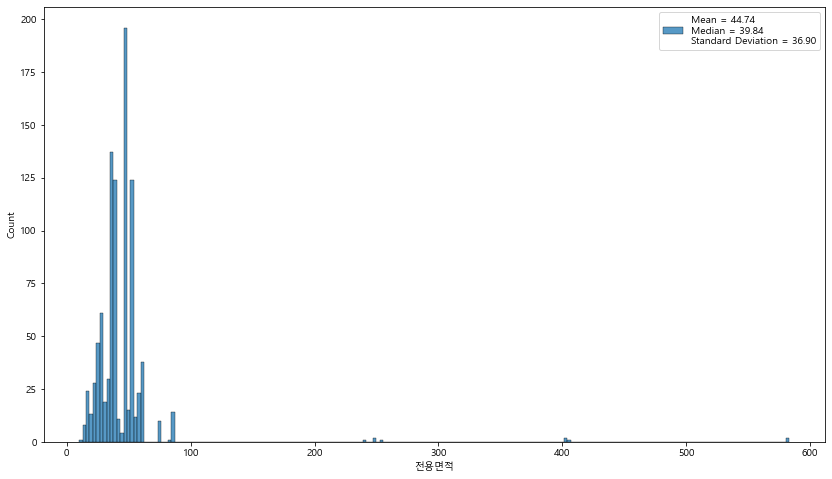

In [145]:
plt.rcParams["figure.figsize"] = (14,8)
label_='Mean = {}\nMedian = {}\nStandard Deviation = {}'.format("%.2f"%test["전용면적"].mean(),test["전용면적"].median(), "%.2f"%test["전용면적"].std())
sns.histplot(x=test["전용면적"], label=label_).legend(loc='best',fontsize=10)
plt.show()

### [한국주택공사_공공임대주택 단지정보](https://www.data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15058476)

In [466]:
filepath = "../"
housing = read_file(os.path.join(filepath,'external_data.csv'))
check_NA(housing)

...There are 2233 duplicates
...Remove them
shape: (95257, 17)
NA check
형명 2272 -> 2.385 %
공급전용면적 1 -> 0.001 %
공급공용면적 9 -> 0.009 %
주택유형명 4357 -> 4.574 %


In [467]:
print(housing.columns)
housing.columns = ['기관명', '광역시도코드', '지역', '시군구코드', '시군구명', '단지명', '도로명주소', '총세대수',
       '공급유형', '형명', '전용면적', '공용면적', '임대건물구분', '주차수', '기본임대보증금', '기본월임대료',
       '기본전환보증금']
print(housing.columns)

Index(['기관명', '광역시도코드', '광역시도명', '시군구코드', '시군구명', '단지명', '도로명주소', '세대수',
       '공급유형명', '형명', '공급전용면적', '공급공용면적', '주택유형명', '주차수', '기본임대보증금', '기본월임대료',
       '기본전환보증금'],
      dtype='object')
Index(['기관명', '광역시도코드', '지역', '시군구코드', '시군구명', '단지명', '도로명주소', '총세대수', '공급유형',
       '형명', '전용면적', '공용면적', '임대건물구분', '주차수', '기본임대보증금', '기본월임대료', '기본전환보증금'],
      dtype='object')


In [468]:
housing.loc[housing.전용면적.isna(), :]

,기관명,광역시도코드,지역,시군구코드,시군구명,단지명,도로명주소,총세대수,공급유형,형명,전용면적,공용면적,임대건물구분,주차수,기본임대보증금,기본월임대료,기본전환보증금
65155,성남시,41,경기도,133,성남시 중원구,매입임대주택,경기도 성남시 중원구 금상로86번길 7-1,5,10년임대,매입임대,NaN,0.0000,다가구주택,0,2000000,31540,0


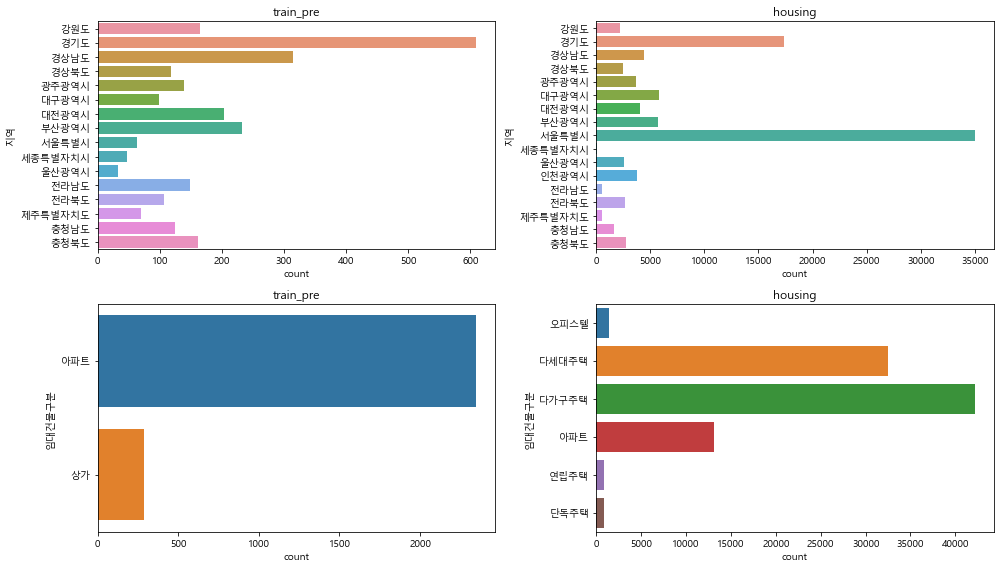

In [469]:
plt.rcParams["figure.figsize"] = (14,8)
fig, ax = plt.subplots(ncols=2,nrows=2)
sns.countplot(y=train_pre['지역'], order=sorted(train_pre['지역'].unique()), ax=ax[0,0]).set_title("train_pre")
sns.countplot(y=housing['지역'], order=sorted(housing['지역'].unique()), ax=ax[0,1]).set_title("housing")
sns.countplot(y=train_pre['임대건물구분'], ax=ax[1,0]).set_title("train_pre")
sns.countplot(y=housing['임대건물구분'], ax=ax[1,1]).set_title("housing")
plt.tight_layout()
plt.show()

In [336]:
print(housing.shape)
housing = housing.loc[housing.지역!="인천광역시",:]
print(housing.shape)

(95257, 17)
(91443, 17)


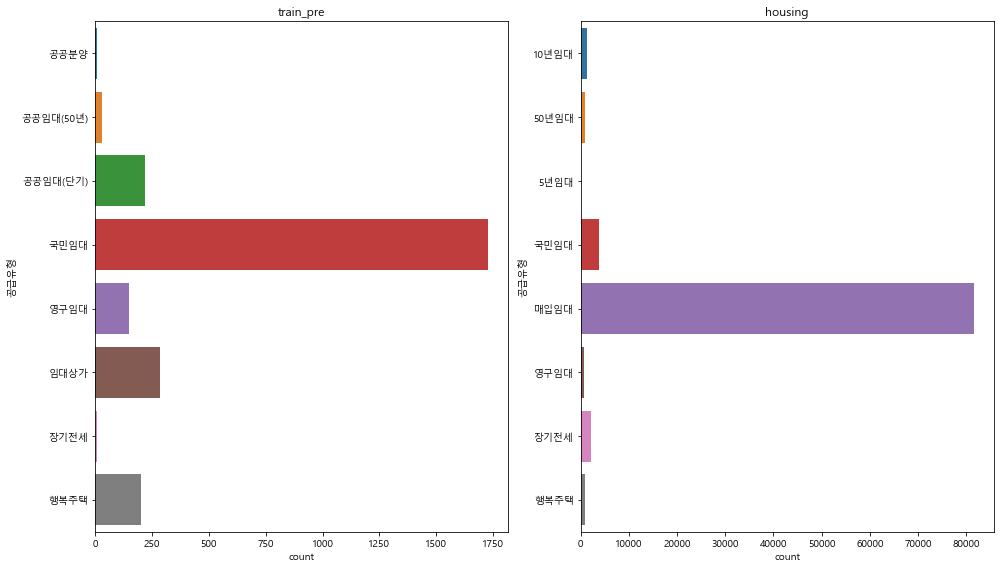

In [337]:
plt.rcParams["figure.figsize"] = (14,8)
fig, ax = plt.subplots(ncols=2)
sns.countplot(y=train_pre['공급유형'], order=sorted(train_pre['공급유형'].unique()), ax=ax[0]).set_title("train_pre")
sns.countplot(y=housing['공급유형'], order=sorted(housing['공급유형'].unique()), ax=ax[1]).set_title("housing")
plt.tight_layout()
plt.show()

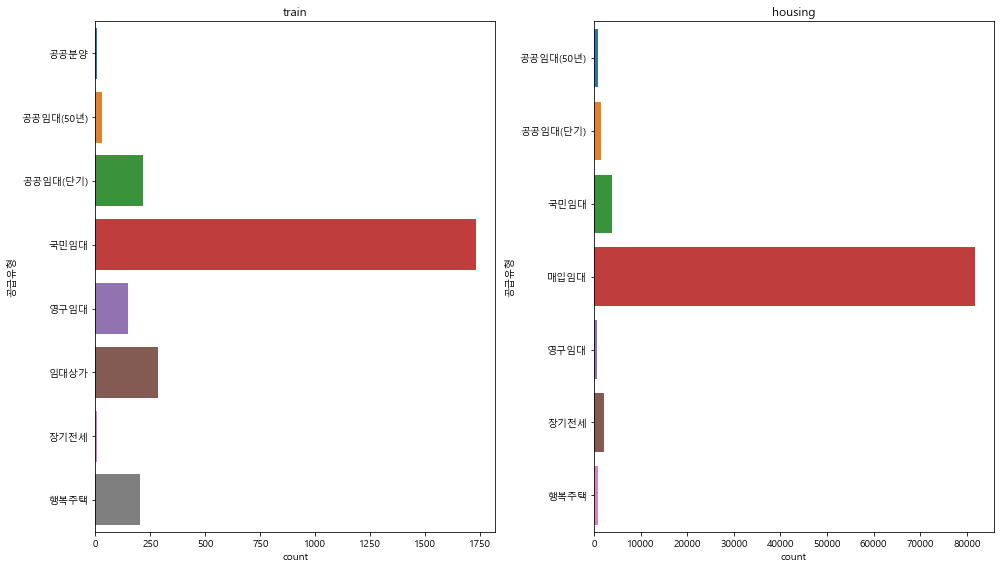

In [338]:
housing.loc[housing.공급유형.isin(['5년임대','10년임대']),'공급유형'] = '공공임대(단기)'
housing.loc[housing.공급유형=='50년임대','공급유형'] = '공공임대(50년)'

plt.rcParams["figure.figsize"] = (14,8)
fig, ax = plt.subplots(ncols=2)
sns.countplot(y=train_pre['공급유형'], order=sorted(train_pre['공급유형'].unique()), ax=ax[0]).set_title("train")
sns.countplot(y=housing['공급유형'], order=sorted(housing['공급유형'].unique()), ax=ax[1]).set_title("housing")
plt.tight_layout()
plt.show()

In [470]:
check_NA(train_pre)
train_pre.shape

NA check
...There's no NA


(2632, 21)

In [435]:
train_pre.loc[(train_pre.단지코드==danji[0])&(train_pre.공급유형=="공공임대(단기)"),:]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역,버스정류장,단지내주차면수,등록차량수,자격유형_카테고리,상가비율,분양세대수,세대당_가능주차면수,분양비율,대형전용면적
2030,C1350,1401,아파트,대전광역시,공공임대(단기),51.9900,106,2.0000,A,"28,013,000.0000","408,600.0000",0.0000,6.0000,"1,636.0000","2,315.0000",1,0.0000,0,1.1677,0.9986,0
2031,C1350,1401,아파트,대전광역시,공공임대(단기),59.9100,13,2.0000,A,"37,474,000.0000","519,350.0000",0.0000,6.0000,"1,636.0000","2,315.0000",1,0.0000,0,1.1677,0.9986,0
2032,C1350,1401,아파트,대전광역시,공공임대(단기),59.9200,223,2.0000,A,"37,385,000.0000","516,130.0000",0.0000,6.0000,"1,636.0000","2,315.0000",1,0.0000,0,1.1677,0.9986,0
2033,C1350,1401,아파트,대전광역시,공공임대(단기),51.9900,146,2.0000,A,"54,612,000.0000","131,130.0000",0.0000,6.0000,"1,636.0000","2,315.0000",1,0.0000,0,1.1677,0.9986,0
2034,C1350,1401,아파트,대전광역시,공공임대(단기),59.9100,32,2.0000,A,"63,585,000.0000","152,680.0000",0.0000,6.0000,"1,636.0000","2,315.0000",1,0.0000,0,1.1677,0.9986,0
2035,C1350,1401,아파트,대전광역시,공공임대(단기),59.9200,170,2.0000,A,"63,501,000.0000","152,480.0000",0.0000,6.0000,"1,636.0000","2,315.0000",1,0.0000,0,1.1677,0.9986,0


In [413]:
housing.loc[(housing.지역=="대전광역시")&(housing.공급유형=="공공임대(단기)")&(housing.전용면적>50),:]
# 관저 LH다온숲 3단지

,기관명,광역시도코드,지역,시군구코드,시군구명,단지명,도로명주소,총세대수,공급유형,형명,전용면적,공용면적,임대건물구분,주차수,기본임대보증금,기본월임대료,기본전환보증금
54659,LH대전충남,30,대전광역시,110,동구,이스트시티,대전광역시 동구 동대전로46번길 120,406,공공임대(단기),59,59.9500,24.0104,아파트,0,32000000,480000,69000000
54660,LH대전충남,30,대전광역시,110,동구,용운마젤란21,대전광역시 동구 대학로 102-7,1,공공임대(단기),84,84.9328,26.7397,아파트,270,0,0,0
56712,LH대전충남,30,대전광역시,170,서구,관저 LH다온숲 3단지,대전광역시 서구 구봉산북로 165,690,공공임대(단기),51,51.9900,18.9280,아파트,0,54612000,131130,17000000
56713,LH대전충남,30,대전광역시,170,서구,관저 LH다온숲 3단지,대전광역시 서구 구봉산북로 165,690,공공임대(단기),59,59.9100,21.8114,아파트,0,37474000,519350,74000000
56714,LH대전충남,30,대전광역시,170,서구,관저 LH다온숲 3단지,대전광역시 서구 구봉산북로 165,690,공공임대(단기),59,59.9200,21.8151,아파트,0,37385000,516130,74000000
57863,LH대전충남,30,대전광역시,200,유성구,일원 대덕연구개발특구 죽동지구내 A5블록,대전광역시 유성구 죽동로 72,492,공공임대(단기),51,51.9800,21.6347,아파트,0,30117000,489360,70000000
57864,LH대전충남,30,대전광역시,200,유성구,일원 대덕연구개발특구 죽동지구내 A5블록,대전광역시 유성구 죽동로 72,492,공공임대(단기),59,59.8900,24.9270,아파트,0,39546000,551310,79000000
57865,LH대전충남,30,대전광역시,200,유성구,일원 대덕연구개발특구 죽동지구내 A5블록,대전광역시 유성구 죽동로 72,492,공공임대(단기),59,59.9400,24.9478,아파트,0,39208000,548860,79000000
57866,LH대전충남,30,대전광역시,200,유성구,일원 대덕연구개발특구 죽동지구내 A5블록,대전광역시 유성구 죽동로 72,492,공공임대(단기),59,59.9500,24.9519,아파트,0,39237000,549050,79000000
57867,LH대전충남,30,대전광역시,200,유성구,일원 대덕연구개발특구 죽동지구내 A5블록,대전광역시 유성구 죽동로 72,492,공공임대(단기),59,59.9800,24.9644,아파트,0,39646000,551960,79000000


In [416]:
train_pre.loc[(train_pre.단지코드==danji3[1]),:]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역,버스정류장,단지내주차면수,등록차량수,자격유형_카테고리,상가비율,분양세대수,세대당_가능주차면수,분양비율,대형전용면적
2622,C2020,40,아파트,부산광역시,행복주택,16.8000,20,7.0000,L,"18,000,000.0000","87,000.0000",1.0000,2.0000,25.0000,19.0000,5,0.0000,0,0.6250,0.8250,0
2623,C2020,40,아파트,부산광역시,행복주택,26.4200,5,7.0000,L,"28,000,000.0000","135,330.0000",1.0000,2.0000,25.0000,19.0000,5,0.0000,0,0.6250,0.8250,0
2624,C2020,40,아파트,부산광역시,행복주택,36.6300,15,7.0000,L,"38,400,000.0000","185,600.0000",1.0000,2.0000,25.0000,19.0000,5,0.0000,0,0.6250,0.8250,0


In [418]:
housing.loc[(housing.지역=="부산광역시")&(housing.공급유형=="행복주택"),:]
# 부산정관 행복주택(A-4BL)

,기관명,광역시도코드,지역,시군구코드,시군구명,단지명,도로명주소,총세대수,공급유형,형명,전용면적,공용면적,임대건물구분,주차수,기본임대보증금,기본월임대료,기본전환보증금
36679,부산도시공사,26,부산광역시,260,동래구,동래 행복주택,부산광역시 동래구 반송로 164,395,행복주택,19A,19.3078,11.9135,아파트,188,23783000,99070,11285485
36680,부산도시공사,26,부산광역시,260,동래구,동래 행복주택,부산광역시 동래구 반송로 164,395,행복주택,19A1,19.3078,11.7734,아파트,188,23783000,99070,11285485
36681,부산도시공사,26,부산광역시,260,동래구,동래 행복주택,부산광역시 동래구 반송로 164,395,행복주택,25A,25.1886,15.2062,아파트,188,30068000,125268,14750625
36682,부산도시공사,26,부산광역시,260,동래구,동래 행복주택,부산광역시 동래구 반송로 164,395,행복주택,29A,29.0646,17.3548,아파트,188,36882000,153629,18222000
36683,부산도시공사,26,부산광역시,260,동래구,동래 행복주택,부산광역시 동래구 반송로 164,395,행복주택,32A,32.5086,19.0013,아파트,188,44880000,187000,22000000
36684,부산도시공사,26,부산광역시,260,동래구,동래 행복주택,부산광역시 동래구 반송로 164,395,행복주택,32A1,32.4158,18.8288,아파트,188,44760000,186500,22000000
36685,부산도시공사,26,부산광역시,260,동래구,동래 행복주택,부산광역시 동래구 반송로 164,395,행복주택,36A,36.4001,21.3273,아파트,188,49396000,205757,23869304
36686,부산도시공사,26,부산광역시,260,동래구,동래 행복주택,부산광역시 동래구 반송로 164,395,행복주택,36B,36.4001,21.3273,아파트,188,49396000,205757,23869304
36687,부산도시공사,26,부산광역시,260,동래구,동래 행복주택,부산광역시 동래구 반송로 164,395,행복주택,36C,36.6935,21.4276,아파트,188,50120000,208800,25000000
36931,LH부산울산,26,부산광역시,290,남구,부산용호(행복주택),부산광역시 남구 동명로 183,14,행복주택,16,16.4400,11.8730,아파트,7,16400000,106600,8000000


## 데이터 병합
### 지역별 남녀 인구수 & 승용차수

In [147]:
print("\n...Before merge")
print(train.shape, test.shape)
train = pd.merge(train, age_gender, on='지역', how='outer')
train = pd.merge(train, car, on='지역', how='outer')

test = pd.merge(test, age_gender.loc[age_gender.지역!="서울특별시",:], on='지역', how='outer')
test = pd.merge(test, car.loc[car.지역!="서울특별시",:], on='지역', how='outer')
print("\n...After merge")
print(train.shape, test.shape)

In [149]:
check_NA(train)
check_NA(test)

NA check
임대보증금 5 -> 0.19 %
임대료 11 -> 0.418 %
NA check
...There's no NA


### 한국주택공사_공공임대주택 단지정보

In [ ]:
어떻게 merge하냐!!!!! 화이팅!!!!!

## 추가) 단지내주차면수를 기준으로 데이터를 분할

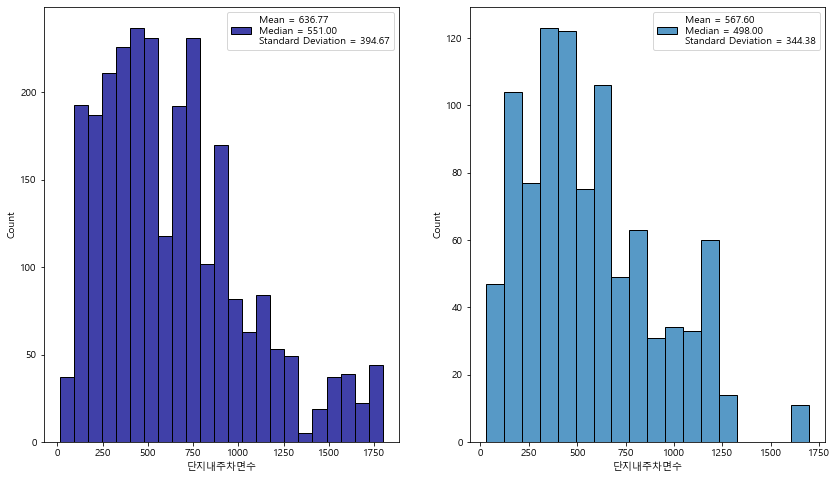

In [151]:
plt.rcParams["figure.figsize"] = (14,8)
fig, ax = plt.subplots(ncols=2)
label_=f"Mean = {train['단지내주차면수'].mean():.2f}\nMedian = {train['단지내주차면수'].median():.2f}\nStandard Deviation = {train['단지내주차면수'].std():.2f}"
sns.histplot(x=train["단지내주차면수"],color="darkblue", label=label_, ax=ax[0]).legend(loc='best',fontsize=10)

label_=f"Mean = {test['단지내주차면수'].mean():.2f}\nMedian = {test['단지내주차면수'].median():.2f}\nStandard Deviation = {test['단지내주차면수'].std():.2f}"
sns.histplot(x=test["단지내주차면수"], label=label_, ax=ax[1]).legend(loc='best',fontsize=10)
plt.show()

In [152]:
pd.DataFrame(train["단지내주차면수"].unique()).describe()

,0
count,355.0000
mean,617.9465
std,378.8537
min,13.0000
25%,331.5000
50%,548.0000
75%,849.0000
max,"1,798.0000"


In [153]:
pd.DataFrame(test["단지내주차면수"].unique()).describe()

,0
count,143.0000
mean,562.8112
std,321.3673
min,29.0000
25%,318.0000
50%,516.0000
75%,743.5000
max,"1,696.0000"


In [154]:
q1=train['단지내주차면수'].quantile(q=0.25, interpolation='nearest')
q3=train['단지내주차면수'].quantile(q=0.75, interpolation='nearest')

In [155]:
train['class_']=0
test['class_']=0

In [156]:
train['class_'].loc[train['단지내주차면수'] <q1]=1
train['class_'].loc[(train['단지내주차면수']>=q1) & (train['단지내주차면수']<q3)]=2 
train['class_'].loc[train['단지내주차면수']>=q3]=3

In [157]:
test['class_'].loc[test['단지내주차면수'] <q1]=1
test['class_'].loc[(test['단지내주차면수']>=q1) & (test['단지내주차면수']<q3)]=2 
test['class_'].loc[test['단지내주차면수']>=q3]=3

In [158]:
train_low=train[train.class_==1]
train_med=train[train.class_==2]
train_high=train[train.class_==3]

In [159]:
test_low=test[test.class_==1]
test_med=test[test.class_==2]
test_high=test[test.class_==3]

In [160]:
# train_low.to_csv('data/train_low.csv', index=False)
# test_low.to_csv('data/test_low.csv', index=False)

# train_med.to_csv('data/train_med.csv', index=False)
# test_med.to_csv('data/test_med.csv', index=False)

# train_high.to_csv('data/train_high.csv', index=False)
# test_high.to_csv('data/test_high.csv', index=False)